# Formation RNAseq CEA - juin 2023

*Enseignantes : Sandrine Caburet et Claire Vandiedonck*

Session IFB : 5 CPU + 21 GB de RAM

# Part 9: Normalisation and Differential Expression analysis with DESeq2 

- 0. 1 - Setting up this R session on IFB core cluster  
- 0. 2 - Parameters to be set or modified by the user   
- 1 - Loading input data: countdata, metadata and gene info
- 2 - Modeling count distribution for each gene with `DESeq()`
- 3 - Normalisation of count distribution with `rlog` and `vst`
- 4 - Differential expression analysis with `DESeq2`   
- 5 - Saving our results for later use : RData file

---
---
## 0 - Getting started
---

### 0.1 - Setting up this R session on IFB core cluster

<em>loaded JupyterLab</em> : Version 3.2.1

In [1]:
## Code cell 1 ##

session_parameters <- function(){
    
    jupytersession <- c(system('echo "=== Cell launched on $(date) ==="', intern = TRUE),
                        system('squeue -hu $USER', intern = TRUE))
    
    jobid <- system("squeue -hu $USER | awk '/jupyter/ {print $1}'", intern = TRUE)
    jupytersession <- c(jupytersession,
                        "=== Current IFB session size: Medium (5CPU, 21 GB) ===",
                        system(paste("sacct --format=JobID,AllocCPUS,NODELIST -j", jobid), intern = TRUE))
    print(jupytersession[1:6])
    
    return(invisible(NULL))
}

session_parameters()

[1] "=== Cell launched on Fri Jun  9 03:53:04 CEST 2023 ==="                        
[2] "          33714862      fast  jupyter cvandied  R      42:56      1 cpu-node-7"
[3] "=== Current IFB session size: Medium (5CPU, 21 GB) ==="                        
[4] "       JobID  AllocCPUS        NodeList "                                      
[5] "------------ ---------- --------------- "                                      
[6] "33714862              5      cpu-node-7 "                                      


__

Next we load into this R session the various tools that we will use.   
***DO NOT worry*** if you see a large red output!! It contains only a warning message, including for functions from different packages sharing the same names.

In [2]:
## Code cell 2 ##

# list the required libraries from the CRAN repository
requiredLib <- c(
     "tidyverse",
    "magrittr",
    "matrixStats",
    "BiocManager",
    "ggplot2"
)

# list the required libraries from the Bioconductor project
requiredBiocLib <- c("DESeq2", "vsn")

# install required libraries if not yet installed
for (lib in requiredLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
    install.packages(lib, quiet = TRUE)
  }
}

for( lib in requiredBiocLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
  BiocManager::install(lib, quiet = TRUE)
  }
}

# load libraries
message("Loading required libraries")
for (lib in requiredLib) {
  library(lib, character.only = TRUE)}
for (lib in requiredBiocLib) {
  library(lib, character.only = TRUE)}

# remove variables from the R session if they are no longer necessary 
rm(lib, requiredLib, requiredBiocLib)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Warning message:
“package ‘BiocManager’ was built under R version 4.0.5”
Bioconductor version '3.12' is out-of-date; the current release version '3.17'
  is available with R version '4.3'; see https://bioconductor.org/install


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, 

In [3]:
## Code cell 3 ##   

cat("Here is my R session with the loaded packages:\n")
sessionInfo()

Here is my R session with the loaded packages:


R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /shared/ifbstor1/software/miniconda/envs/r-4.0.3/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] vsn_3.58.0                  DESeq2_1.30.1              
 [3] SummarizedExperiment_1.20.0 Biobase_2.50.0             
 [5] MatrixGenerics_1.2.1        GenomicRanges_1.42.0       
 [7] GenomeInfoDb_1.26.7         IRanges_2.24.1             
 [9] S4Vectors_0.28.

---
### 0.2 - Parameters to be set or modified by the user
---


- Using a full path with a `/` at the end, **define the folder** of the project as  `gohome` variable, and the folder where you work as the `myfolder` variable:

<div class="alert alert-block alert-warning"> <b> Warning on working directory: </b><br>In a Jupyter Hub and a jupyter notebook in R, by default the working directory is where the notebook is opened for the <b> fisrt time </b>. Even if you move it ton another directory, it keeps the original working diretory unless you set it again with the function <code>setwd()</code>.</div>

In [4]:
## Code cell 4 ##

gohome <- "/shared/projects/2312_rnaseq_cea/"
gohome

myfolder <- getwd()
myfolder

[1] "/shared/projects/2312_rnaseq_cea/"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck"

- With a `/` at the end, define the path to the folder where the results of this analysis with `DESeq2` will be stored:

In [5]:
## Code cell 5 ##

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste(myfolder,"/Results/deseq2/", sep = ""), recursive = TRUE)

# storing the path to this output folder in a variable
deseq2folder <- paste(myfolder,"/Results/deseq2/", sep = "")
deseq2folder

# listing the content of the folder
print(system(paste("ls -hlt", deseq2folder), intern = TRUE) )

Warning message in dir.create(paste(myfolder, "/Results/deseq2/", sep = ""), recursive = TRUE):
“'/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/deseq2' already exists”


[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/deseq2/"

[1] "total 1.6M"                                                                                 
[2] "-rw-rw----+ 1 cvandiedonck cvandiedonck 1.6M Jun  9 03:50 DESeq2_significant_genes-0_05.tsv"


- Last, we specify the size of the graphical outputs that will be used for all the plots in the notebook.    
This setting could be modified at will for each plot. 

In [6]:
## Code cell 6 ##

options(repr.plot.width = 15, repr.plot.height = 8) # for figure display in the notebook

---
---
## 1 - Loading data
---

### 1.1 - Count data and metadata
---

First we need to retrieve the counts data and the metadata about samples. As we stored those in a global `.RData` object at the end of "Pipe_08", we can simply reload all our information by openig this .Rdata object. 

In [7]:
## Code cell 7 ##

pca1folder <- paste0(myfolder,"/Results/pca1/")
pca1folder
rdata <- paste0(pca1folder,"RawCounts_Samples.RData")
rdata
load(rdata,verbose = T)
rm(pca1folder) # not used any further

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/pca1/"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/pca1/RawCounts_Samples.RData"

Loading objects:
  countdata
  samples
  conditionColor


We list all the objects we have currently in our session: 

In [8]:
## Code cell 8 ##

ls() 

[1] "conditionColor"     "countdata"          "deseq2folder"      
[4] "gohome"             "myfolder"           "rdata"             
[7] "samples"            "session_parameters"

We can now see it contains the two following dataframes:

- `countdata`: the dataframe containing all the read counts produced by `featureCounts` (as in the Pipe_06 notebook), ***on all 11 samples***, without the low counts genes.      
- `samples`:  the metadata dataframe containing the information about the samples, in particular the conditions of the experiment.

We will verify their content and structure.

***-> Let's start with the `samples` object containing the metadata.*** We see below it has 11 rows, one per sample.

In [9]:
## Code cell 9 ##

samples # since we have only 11 rows, we can easily print the whole file. We could aslo have used head(samples, n=11).
str(samples)

SampleID,SampleName,Condition,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SRR12730403,dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730404,dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730405,dHet_B-ALL_713_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805162,GSM4805162,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730406,dHet_B-ALL_713_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805163,GSM4805163,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730407,dHet_B-ALL_760_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805164,GSM4805164,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730408,dHet_B-ALL_760_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805165,GSM4805165,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
SRR12730409,dHet_FetalLiver_proB_rep1,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805166,GSM4805166,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
SRR12730410,dHet_FetalLiver_proB_rep2,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805167,GSM4805167,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
SRR12730411,dHet_FetalLiver_proB_rep3,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805168,GSM4805168,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate3",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver


'data.frame':	11 obs. of  10 variables:
 $ SampleID           : chr  "SRR12730403" "SRR12730404" "SRR12730405" "SRR12730406" ...
 $ SampleName         : chr  "dHet_B-ALL_686_rep1" "dHet_B-ALL_686_rep2" "dHet_B-ALL_713_rep1" "dHet_B-ALL_713_rep2" ...
 $ Condition          : chr  "dHet" "dHet" "dHet" "dHet" ...
 $ Genotype           : chr  "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" ...
 $ GEO_Accession..exp.: chr  "GSM4805160" "GSM4805161" "GSM4805162" "GSM4805163" ...
 $ Sample.Name        : chr  "GSM4805160" "GSM4805161" "GSM4805162" "GSM4805163" ...
 $ source_name        : chr  "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate1" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate2" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate1" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate2" ...
 $ SRA.Study          : chr  "SRP

***-> We verify now that the raw `countdata` dataframe look like what we expect*** by checking the first rows and it structure. We see below it has 12 columns, one for Geneid and the other ones for each sample, while genes are present in rows.

In [10]:
## Code cell 10 ##

head(countdata)
str(countdata)

,Geneid,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
20,ENSMUSG00000025902.14,3,0,64,56,126,172,0,0,0,0,1
21,ENSMUSG00000104238.2,0,0,0,0,2,11,0,0,0,0,0
22,ENSMUSG00000102269.2,3,4,2,0,2,4,2,1,1,2,2
27,ENSMUSG00000098104.2,190,160,185,175,203,153,227,109,162,257,214
28,ENSMUSG00000102175.2,0,2,1,4,0,2,0,0,2,3,1
31,ENSMUSG00000103922.2,62,56,49,39,68,34,28,21,29,57,50


'data.frame':	22927 obs. of  12 variables:
 $ Geneid                   : chr  "ENSMUSG00000025902.14" "ENSMUSG00000104238.2" "ENSMUSG00000102269.2" "ENSMUSG00000098104.2" ...
 $ dHet_B-ALL_686_rep1      : int  3 0 3 190 0 62 7954 9 12 5960 ...
 $ dHet_B-ALL_686_rep2      : int  0 0 4 160 2 56 6164 8 9 4289 ...
 $ dHet_B-ALL_713_rep1      : int  64 0 2 185 1 49 3329 2 15 3263 ...
 $ dHet_B-ALL_713_rep2      : int  56 0 0 175 4 39 3503 11 20 3178 ...
 $ dHet_B-ALL_760_rep1      : int  126 2 2 203 0 68 6714 6 17 4742 ...
 $ dHet_B-ALL_760_rep2      : int  172 11 4 153 2 34 5551 3 19 4173 ...
 $ dHet_FetalLiver_proB_rep1: int  0 0 2 227 0 28 2924 3 0 3933 ...
 $ dHet_FetalLiver_proB_rep2: int  0 0 1 109 0 21 2616 4 1 3515 ...
 $ dHet_FetalLiver_proB_rep3: int  0 0 1 162 2 29 3816 6 6 3518 ...
 $ wt_BoneMar_proB_rep1     : int  0 0 2 257 3 57 3820 8 7 4091 ...
 $ wt_BoneMar_proB_rep2     : int  1 0 2 214 1 50 3115 5 0 3707 ...


-> ***Most importantly**, to ensure the **metadata `samples` and `countData` dataframes have the same sample names***, we run the code below. It tests for equality in the sample names in both dataframes, in the colnames of countdata (except column 1 for gene ids) and the column "SampleName" in samples. This will return TRUE for each name, if theay are the same in both files. The `table()` function counts how many are equal. In all there are 11 samples in both files.

In [11]:
## Code cell 11 ##

table(colnames(countdata[,-1]) == samples$SampleName, useNA = "ifany")


TRUE 
  11 

### 1.2 - Annotation of genes in `gene_info`
---

In the above `countdata` dataframe, we can notice the genes are only indicated with their Ensembl GeneID (http://www.ensembl.org/Mus_musculus/Info/Index). It will thus be useful to obtain further information, including gene names or coordinates.

To do so we create a `genecode`dataframe from the Gencode annotation GTF file of the mouse genome. We have already downloaded it for all users of the project in `/shared/projects/2312_rnaseq_cea/allData/Reference/` from this link: https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M32/gencode.vM32.annotation.gtf.gz. It can easily be done in bash with the `wget` command or its equivalent `wget()` fonction in R.

-> We now import it into R and look at its structure and the first rows.

In [12]:
## Code cell 12 ##

gencode <- read_tsv("/shared/projects/2312_rnaseq_cea/allData/Reference/gencode.vM32.primary_assembly.annotation.gtf.gz",
                                     skip = 5, col_names = F, show_col_types = FALSE)


In [13]:
## Code cell 13 ##

str(gencode)
head(gencode)

spec_tbl_df [1,904,516 × 9] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ X1: chr [1:1904516] "chr1" "chr1" "chr1" "chr1" ...
 $ X2: chr [1:1904516] "HAVANA" "HAVANA" "HAVANA" "ENSEMBL" ...
 $ X3: chr [1:1904516] "gene" "transcript" "exon" "gene" ...
 $ X4: num [1:1904516] 3143476 3143476 3143476 3172239 3172239 ...
 $ X5: num [1:1904516] 3144545 3144545 3144545 3172348 3172348 ...
 $ X6: chr [1:1904516] "." "." "." "." ...
 $ X7: chr [1:1904516] "+" "+" "+" "+" ...
 $ X8: chr [1:1904516] "." "." "." "." ...
 $ X9: chr [1:1904516] "gene_id \"ENSMUSG00000102693.2\"; gene_type \"TEC\"; gene_name \"4933401J01Rik\"; level 2; mgi_id \"MGI:1918292"| __truncated__ "gene_id \"ENSMUSG00000102693.2\"; transcript_id \"ENSMUST00000193812.2\"; gene_type \"TEC\"; gene_name \"493340"| __truncated__ "gene_id \"ENSMUSG00000102693.2\"; transcript_id \"ENSMUST00000193812.2\"; gene_type \"TEC\"; gene_name \"493340"| __truncated__ "gene_id \"ENSMUSG00000064842.3\"; gene_type \"snRNA\"; gene_name \"Gm26206\"; 

X1,X2,X3,X4,X5,X6,X7,X8,X9
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
chr1,HAVANA,gene,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; gene_type ""TEC""; gene_name ""4933401J01Rik""; level 2; mgi_id ""MGI:1918292""; havana_gene ""OTTMUSG00000049935.1"";"
chr1,HAVANA,transcript,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ""ENSMUST00000193812.2""; gene_type ""TEC""; gene_name ""4933401J01Rik""; transcript_type ""TEC""; transcript_name ""4933401J01Rik-201""; level 2; transcript_support_level ""NA""; mgi_id ""MGI:1918292""; tag ""basic""; tag ""Ensembl_canonical""; havana_gene ""OTTMUSG00000049935.1""; havana_transcript ""OTTMUST00000127109.1"";"
chr1,HAVANA,exon,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ""ENSMUST00000193812.2""; gene_type ""TEC""; gene_name ""4933401J01Rik""; transcript_type ""TEC""; transcript_name ""4933401J01Rik-201""; exon_number 1; exon_id ""ENSMUSE00001343744.2""; level 2; transcript_support_level ""NA""; mgi_id ""MGI:1918292""; tag ""basic""; tag ""Ensembl_canonical""; havana_gene ""OTTMUSG00000049935.1""; havana_transcript ""OTTMUST00000127109.1"";"
chr1,ENSEMBL,gene,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; gene_type ""snRNA""; gene_name ""Gm26206""; level 3; mgi_id ""MGI:5455983"";"
chr1,ENSEMBL,transcript,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ""ENSMUST00000082908.3""; gene_type ""snRNA""; gene_name ""Gm26206""; transcript_type ""snRNA""; transcript_name ""Gm26206-201""; level 3; transcript_support_level ""NA""; mgi_id ""MGI:5455983""; tag ""basic""; tag ""Ensembl_canonical"";"
chr1,ENSEMBL,exon,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ""ENSMUST00000082908.3""; gene_type ""snRNA""; gene_name ""Gm26206""; transcript_type ""snRNA""; transcript_name ""Gm26206-201""; exon_number 1; exon_id ""ENSMUSE00000522066.2""; level 3; transcript_support_level ""NA""; mgi_id ""MGI:5455983""; tag ""basic""; tag ""Ensembl_canonical"";"


We can see above that it contains 190,516 genes in rows and 9 columns with the chromosome, the curated source (HAVANA or ENSEMBL), the type of gene, the start and end position on the chromosome and the strand.

The last column includes many information including gene_id, gene_type, gene_name, MGI_id or Havana ID. Its structure is complicated and we will parse it to sperate fields delimited by ";". In addition, we will only select annotations with the type "gene". This will be done with some R commands of the `tidyverse` package (https://www.tidyverse.org/). Do not worry with the warning message. It occured because some genes have not all fileds filled in the last column.

In [14]:
## Code cell 14 ##

gencode %<>% filter(X3=="gene")
gencode %<>% dplyr::select(X1,X2, X4,X5,X7,X9) 
#gencode %<>% rename(chr=X1, annotation=X2, start=X4, end=X5, strand=X7)
names(gencode)[1:5] <- c("chr", "annotation", "start", "end", "strand")
gencode %<>% separate(X9, into = c("gene_id", "gene_type", "gene_name", "level", "mgi_id", "havana_gene"), sep = ";")
gencode %<>% mutate(gene_id = str_remove(gene_id, "gene_id \""),
                   gene_type = str_remove(gene_type, " gene_type \""), 
                   gene_name = str_remove(gene_name, " gene_name \""),
                   mgi_id = str_remove(mgi_id, " mgi_id \""),
                   havana_gene = str_remove(havana_gene, " havana_gene \""))
gencode %<>% mutate(gene_id = str_remove(gene_id, "\""),
                   gene_type = str_remove(gene_type, "\""), 
                   gene_name = str_remove(gene_name, "\""),
                   mgi_id = str_remove(mgi_id, "\""), 
                   havana_gene = str_remove(havana_gene, "\""))

Warning message:
“Expected 6 pieces. Additional pieces discarded in 48950 rows [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 1236 rows [34, 69, 173, 446, 643, 658, 675, 713, 773, 887, 932, 950, 971, 975, 1122, 1171, 1194, 1195, 1216, 1262, ...].”


Let's have a look at the generated file.

In [15]:
## Code cell 15 ##

str(gencode)
head(gencode)

tibble [57,010 × 11] (S3: tbl_df/tbl/data.frame)
 $ chr        : chr [1:57010] "chr1" "chr1" "chr1" "chr1" ...
 $ annotation : chr [1:57010] "HAVANA" "ENSEMBL" "HAVANA" "HAVANA" ...
 $ start      : num [1:57010] 3143476 3172239 3276124 3322980 3435954 ...
 $ end        : num [1:57010] 3144545 3172348 3741721 3323459 3438772 ...
 $ strand     : chr [1:57010] "+" "+" "-" "+" ...
 $ gene_id    : chr [1:57010] "ENSMUSG00000102693.2" "ENSMUSG00000064842.3" "ENSMUSG00000051951.6" "ENSMUSG00000102851.2" ...
 $ gene_type  : chr [1:57010] "TEC" "snRNA" "protein_coding" "processed_pseudogene" ...
 $ gene_name  : chr [1:57010] "4933401J01Rik" "Gm26206" "Xkr4" "Gm18956" ...
 $ level      : chr [1:57010] " level 2" " level 3" " level 2" " level 2" ...
 $ mgi_id     : chr [1:57010] "MGI:1918292" "MGI:5455983" "MGI:3528744" "MGI:5011141" ...
 $ havana_gene: chr [1:57010] "OTTMUSG00000049935.1" "" "OTTMUSG00000026353.2" "OTTMUSG00000049958.1" ...


chr,annotation,start,end,strand,gene_id,gene_type,gene_name,level,mgi_id,havana_gene
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,HAVANA,3143476,3144545,+,ENSMUSG00000102693.2,TEC,4933401J01Rik,level 2,MGI:1918292,OTTMUSG00000049935.1
chr1,ENSEMBL,3172239,3172348,+,ENSMUSG00000064842.3,snRNA,Gm26206,level 3,MGI:5455983,
chr1,HAVANA,3276124,3741721,-,ENSMUSG00000051951.6,protein_coding,Xkr4,level 2,MGI:3528744,OTTMUSG00000026353.2
chr1,HAVANA,3322980,3323459,+,ENSMUSG00000102851.2,processed_pseudogene,Gm18956,level 2,MGI:5011141,OTTMUSG00000049958.1
chr1,HAVANA,3435954,3438772,-,ENSMUSG00000103377.2,TEC,Gm37180,level 2,MGI:5610408,OTTMUSG00000049960.1
chr1,HAVANA,3445779,3448011,-,ENSMUSG00000104017.2,TEC,Gm37363,level 2,MGI:5610591,OTTMUSG00000049961.1


It is a `tibble`, a sort of dataframe object with slightly different properties. For example, it does not have row names. It is appropriate for large datasets.

The file contains now **57,010 Ensembl IDs**. 

***-> Could we only use the gene name for further analyses?***

In [16]:
## Code cell 16 ##

table(table(gencode$gene_name))
length(unique(gencode$gene_id))
length(unique(gencode$gene_name))


    1     2     3 
56713   144     3 

[1] 57010

[1] 56860

As you can see, the file contains 56,860 unique gene names: 56,713 have a unique gene ID, while 3 genes have 3 different Ensembl ID and 144 genes have 2 Ensembl IDs. We will keep them all and write the parsed gene_info file on our personal directory in the Data folder.

In [17]:
## Code cell 17 ##

write.table(gencode, file = paste0(myfolder, "/Data/gene_info.txt"), quote=F, sep="\t", row.names = F, col.names = T)

**=> Great!!** All is set now to perform normalisation and differential expression analysis with `DESeq2`.

---
---
## 2 - Modeling count distribution for each gene using library size factor and dispersion estimation with `DESeq2`
---

[**DESeq2**](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) is among the best packages to perform modeling, normalisation and differential expression of quantitative omics data. It uses the **effective library size** method that assumes a majority of transcripts is not differentially expressed. DESeq2 defines a virtual reference sample by taking the median of each gene’s values across samples and then computes size factors as the median of ratios of each sample to the reference sample.

Of note, other packages using the same method that we could also use are [***EdgeR***](https://bioconductor.org/packages/release/bioc/html/edgeR.html) and [***limma***](https://bioconductor.org/packages/release/bioc/html/limma.html).

All are available on the [Bioconductor project](https://www.bioconductor.org/). 

<div class="alert alert-block alert-warning"> <b> <u>Caution on normalized and un-normalized counts: </u></b><br>
In a workflow, DESeq2 can be used twice, with two objectives:<ol>
    <li><b>generation of normalized counts, exclusively to run exploratory analyses</b>, in particular downstream visualization and analyses of results.</il>
    <li><b>differential expression analysis without using the normalized counts</b>, the model being designed to account for the library size differences internally. DE of each gene are tested using a Generalized Linear Model (GLM) of the negative bonomial family </il>
    </ol></div>

For both these objectives, there are <u>**several common steps**</u>. DESeq2 will:
- model the raw counts distribution using the ***size factors*** to account for differences in library depth
- estimate the ***gene-wise dispersion*** and shrink these estimates to generate accurate ***estimates of dispersion*** to model the counts
- fit curve to gene-wise dispersion estimates folowing a ***negative binomial model***

These common steps have been wrapped into a single function, `DESeq()`. More details on the respective steps can be found in the DESeq2 paper and in the tutorial available in the package vignette at https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#the-deseqdataset. You could also type and run `?DESeq` to read more on the steps.

Below, we will see first how to generate a DESeq data object and how to model the count distributions. Then we will focus on the part generating normalized counts for downtream exploratory analyses. We will finish with the DE analysis using un-normalized counts.

### 2.1 - Create the `DESeqDataSet` object
---

DESeq2 uses an object called `DESeqDataSet` to store read counts and other intermediate calculations needed for normalisation and differential expression analysis. This is represented in the code below as ***dds*** (*d* for DESeq, *d* for Data and *s* for set). The basic idea behind this is to coerce the countdata and metadata, and any other relevant associated information, into slots of a single R object that DESeq2 can accept and work with. We do this with the `DESeqDataSetFromMatrix()` function.

#### **2.1.a - preparation of countdata matrix for DESeq2**

DESeq2 can use inputs generated from different tools. For counts data, they can be either matrices of counts, or homogeneuous dataframes with no other additional columns than the counts for each sample.

<div class="alert alert-block alert-danger"> <b> Caution on input counts: </b><br>
    <ul>
        <li> DESeq2 requires <b>raw un-normalized counts</b>, without prior normalisation of any kind, not even with log2.<il>
        <li> The counts must be <b>non-negative integers</b>. So if your matrix was generated with Salmon with pseudo counts, you have to round the values to the nearest integer.<il>
        </div>



Several steps must be carried out to model the gene count distribbutions:


- **Pre-Filter on low input genes**

For genes with low counts across samples, we will miss statistical power to detect differential expression. Keeping those genes in the dataset will also reduce the statistical power to detect other differentially expressed genes because it increases the number of multiple tests. In addition, if you work in a low-memory setting, it is preferable to reduce the size of the matrix to ease its handling,

A general rule is thus to remove genes with a total number of reads across samples below the number of samples, as we did in Pipe_08. It is recommanded to  perform this prefiltering before any normalization step. A filtering process is included in DESeq2 but we will run it before for clarity and compatibility with other normalization tools. 

Here, there are 57,010 genes analysed in our samples, if the genes with a null or a low expression were not filtered out. `DESeq2` can take care of these genes along the way, so we could have kept those. Nevertheless, here we will go on with the `countdata`dataframe, without low counts genes we got rid off in Pipe_08 by using as input the `countdata`dataframe that is already computed and contains 22,977 genes.   

In [18]:
## Code cell 18 ##

nrow(countdata) # 22927 in counts
str(countdata)

[1] 22927

'data.frame':	22927 obs. of  12 variables:
 $ Geneid                   : chr  "ENSMUSG00000025902.14" "ENSMUSG00000104238.2" "ENSMUSG00000102269.2" "ENSMUSG00000098104.2" ...
 $ dHet_B-ALL_686_rep1      : int  3 0 3 190 0 62 7954 9 12 5960 ...
 $ dHet_B-ALL_686_rep2      : int  0 0 4 160 2 56 6164 8 9 4289 ...
 $ dHet_B-ALL_713_rep1      : int  64 0 2 185 1 49 3329 2 15 3263 ...
 $ dHet_B-ALL_713_rep2      : int  56 0 0 175 4 39 3503 11 20 3178 ...
 $ dHet_B-ALL_760_rep1      : int  126 2 2 203 0 68 6714 6 17 4742 ...
 $ dHet_B-ALL_760_rep2      : int  172 11 4 153 2 34 5551 3 19 4173 ...
 $ dHet_FetalLiver_proB_rep1: int  0 0 2 227 0 28 2924 3 0 3933 ...
 $ dHet_FetalLiver_proB_rep2: int  0 0 1 109 0 21 2616 4 1 3515 ...
 $ dHet_FetalLiver_proB_rep3: int  0 0 1 162 2 29 3816 6 6 3518 ...
 $ wt_BoneMar_proB_rep1     : int  0 0 2 257 3 57 3820 8 7 4091 ...
 $ wt_BoneMar_proB_rep2     : int  1 0 2 214 1 50 3115 5 0 3707 ...


- **Need genes as row names**

For DESeq2, counts must be provided in a matrix, or dataframe, with genes in rows put as row names, while there are only samples in columns. No additional column must be present. We reformat countdata accordingly.

In [19]:
## Code cell 19 ##

row.names(countdata) <- countdata[,"Geneid"] # here we used the name of the column, we could also have put the index (i.e) without quotes
countdata <- countdata[,-1] # to remove the first column

We check this formating was effective.

In [20]:
## Code cell 20 ##

head(countdata)

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000025902.14,3,0,64,56,126,172,0,0,0,0,1
ENSMUSG00000104238.2,0,0,0,0,2,11,0,0,0,0,0
ENSMUSG00000102269.2,3,4,2,0,2,4,2,1,1,2,2
ENSMUSG00000098104.2,190,160,185,175,203,153,227,109,162,257,214
ENSMUSG00000102175.2,0,2,1,4,0,2,0,0,2,3,1
ENSMUSG00000103922.2,62,56,49,39,68,34,28,21,29,57,50


We run a final check on sample names that must be identical and in the same order in the coundata and samples dataframe.

In [21]:
## Code cell 21 ##

all(names(countdata) == samples$SampleName)

[1] TRUE

#### **2.1.b - preparation of sample_info (*metadata*) matrix for DESEq2**

- **sample names**

It is recommanded for DESeq2 to put sample names as row names of the matrix, in addition to the column/variable where they already are.

In [22]:
## Code cell 22 ##

row.names(samples) <- samples[,"SampleName"]
head(samples)

,SampleID,SampleName,Condition,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
dHet_B-ALL_686_rep1,SRR12730403,dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_686_rep2,SRR12730404,dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_713_rep1,SRR12730405,dHet_B-ALL_713_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805162,GSM4805162,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_713_rep2,SRR12730406,dHet_B-ALL_713_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805163,GSM4805163,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_760_rep1,SRR12730407,dHet_B-ALL_760_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805164,GSM4805164,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_760_rep2,SRR12730408,dHet_B-ALL_760_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805165,GSM4805165,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node


* **Factorisation**  

Categorical variables of interest to make comparisons must be formatted as factors in R for DESeq2.

We have to tell DESeq2 which information is used as a *factor*, meaning the one(s) that is going to be used as a way to separate groups for future comparisons.   
This is done by using the `factor()` function, and providing the name of the column containing this information, and the various values that this info can take.   
Feeding this factorisation into our samples dataframe changes the way this column will be read: as a factor instead of mere characters. 
   
 

In [23]:
## Code cell 23 ##

samples$Condition <- factor(samples$Condition, levels = c("WT", "dHet", "dHetRag" ))

We can verify that this factorisation worked, by showing how many samples were placed in each group:

In [24]:
## Code cell 24 ##

table(samples$Condition)


     WT    dHet dHetRag 
      2       6       3 

and by checking the levels included in that factor or checking the structure of the factor itself:

In [25]:
## Code cell 25 ##

levels(samples$Condition)
str(samples$Condition)

[1] "WT"      "dHet"    "dHetRag"

 Factor w/ 3 levels "WT","dHet","dHetRag": 2 2 2 2 2 2 3 3 3 1 ...


  Alternatively, the `relevel()` function can also be used to clearly specify which level is used as a reference. Most of the times, it will be the WT condition.  

In [26]:
## Code cell 26 ##

samples$Condition <- relevel(samples$Condition, ref = "WT")

In [27]:
## Code cell 27 ##

table(samples$Condition)


     WT    dHet dHetRag 
      2       6       3 

If we look at our `samples`dataframe, we can now see that our `Condition`column is marked as a factor: **fct**

In [28]:
## Code cell 28 ##

head(samples, n = 2)
str(samples)

,SampleID,SampleName,Condition,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
dHet_B-ALL_686_rep1,SRR12730403,dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
dHet_B-ALL_686_rep2,SRR12730404,dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node


'data.frame':	11 obs. of  10 variables:
 $ SampleID           : chr  "SRR12730403" "SRR12730404" "SRR12730405" "SRR12730406" ...
 $ SampleName         : chr  "dHet_B-ALL_686_rep1" "dHet_B-ALL_686_rep2" "dHet_B-ALL_713_rep1" "dHet_B-ALL_713_rep2" ...
 $ Condition          : Factor w/ 3 levels "WT","dHet","dHetRag": 2 2 2 2 2 2 3 3 3 1 ...
 $ Genotype           : chr  "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" ...
 $ GEO_Accession..exp.: chr  "GSM4805160" "GSM4805161" "GSM4805162" "GSM4805163" ...
 $ Sample.Name        : chr  "GSM4805160" "GSM4805161" "GSM4805162" "GSM4805163" ...
 $ source_name        : chr  "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate1" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate2" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate1" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate2" ...
 $ S

#### **2.1.c - Create the `dds` object**

We can now create the `dds` object with 3 inputs:

- `countdata` dataframe as ar argument to the the option countData
- `samples` dataframe as an argument of the option colData
- `experimental design` to define the formula of the gene expression linear model

For a good tutorial on defining models with different type of experimental designs (one factor with 2 levels, one factor with 3 levles, two factors, two nested factors, paired samples...), see this [tutorial](https://github.com/tavareshugo/tutorial_DESeq2_contrasts/blob/main/DESeq2_contrasts.md) and companion [slides](https://docs.google.com/presentation/d/1B9zW1_F-kBqQEu4xqxIJrudYP5DecytYMRR6bY4H6aM/edit). For more complex designs see chapter 8 of limma package [userguide](https://bioconductor.org/packages/release/bioc/vignettes/limma/inst/doc/usersguide.pdf).

<div class="alert alert-block alert-danger"> <b> Caution on design: </b><br>The full design must be specified at the beginning of the analysis. It is used by all  DESeq2 functions treating samples except for the setp of the size factor estimation. The design formula should have all of the factors in your metadata that account for major sources of variation of gene expression in your experiment. This includes you factor(s) of interest. Add also any covariates (eg age or sex). You may have prior knowledge of the sources of variation (example with covariates) or you may have identified them during the QC. It is critical to include all factors in your design formula. Unfortunately, it reduces your power but without including them you may end up with inacurate results. The design formula can be changed later if you want to change the reference level or factor. </div>

Here the dataset has a nested design (condisering the double mutation or the proB state) but we are missing replicates to evaluate variation in each group.
For simplicity, we will only consider the "Condition" factor defining the "dHet", "dHetRag" and "WT" levels.

Let's create the `dds`  object with the `DESeqDataSetFromMatrix()` function dedicated to count matrices as inputs. *(Note that other function exist to import results of other R packages)*.


In [29]:
## Code cell 29 ##

# round() is used as a security, because DESeq2 works only in integers. Read counts should be integers.
# Be careful: countData is the name of a variable for this function, and countdata is the name of our dataframe

dds <- DESeq2::DESeqDataSetFromMatrix(countData = round(countdata, digits = 0),
                              colData = samples,
                              design = ~ Condition)

converting counts to integer mode



We check the number of genes in the dataset

In [30]:
## Code cell 30 ##

nrow(dds) # 22927 in counts

[1] 22927

We can also print dds and see that the assay slot contains the raw counts that were in countdata dataframe. We can even extract it back from dds with the function `assay().`

In [31]:
## Code cell 31 ##
dds

class: DESeqDataSet 
dim: 22927 11 
metadata(1): version
assays(1): counts
rownames(22927): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00000095742.2 ENSMUSG00000095041.8
rowData names(0):
colnames(11): dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 ...
  wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
colData names(10): SampleID SampleName ... Strain Tissue

In [32]:
## Code cell 32 ##
head(assay(dds)) # same as coutdata

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
ENSMUSG00000025902.14,3,0,64,56,126,172,0,0,0,0,1
ENSMUSG00000104238.2,0,0,0,0,2,11,0,0,0,0,0
ENSMUSG00000102269.2,3,4,2,0,2,4,2,1,1,2,2
ENSMUSG00000098104.2,190,160,185,175,203,153,227,109,162,257,214
ENSMUSG00000102175.2,0,2,1,4,0,2,0,0,2,3,1
ENSMUSG00000103922.2,62,56,49,39,68,34,28,21,29,57,50


### 2.2 - Run the DESeq analysis on the dds object
---

Next, the `DEseq` function performs the 3 following steps on the dds object we created:

    1.Estimation of size factors
    2.Estimation of dispersion
    3.Negative Binomial GLM fitting and Wald statistic 
    
For detailed explanation, please refer to the DESeq2 links above.
In this section, we will discuss the first two steps. The test part will be presented in part 4 of this notebook.

In [33]:
## Code cell 33 ##

dds2 <- DESeq2::DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Let's inspect the newly created object dds2. *(Note that in most tutorials, they often replace dds here. In fact, the dds object is completed with the results of the 3 steps. For clarity, we recalled the object dds2).*

In [34]:
## Code cell 34 ##

dds2

class: DESeqDataSet 
dim: 22927 11 
metadata(1): version
assays(4): counts mu H cooks
rownames(22927): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00000095742.2 ENSMUSG00000095041.8
rowData names(26): baseMean baseVar ... deviance maxCooks
colnames(11): dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 ...
  wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
colData names(11): SampleID SampleName ... Tissue sizeFactor

The portion `assays` within `dds2` contains the expression data, still not normalized:

In [35]:
## Code cell 35 ##

head(assay(dds2))

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
ENSMUSG00000025902.14,3,0,64,56,126,172,0,0,0,0,1
ENSMUSG00000104238.2,0,0,0,0,2,11,0,0,0,0,0
ENSMUSG00000102269.2,3,4,2,0,2,4,2,1,1,2,2
ENSMUSG00000098104.2,190,160,185,175,203,153,227,109,162,257,214
ENSMUSG00000102175.2,0,2,1,4,0,2,0,0,2,3,1
ENSMUSG00000103922.2,62,56,49,39,68,34,28,21,29,57,50


The `counts()` function with default parameters also returns the same raw counts stored in the assays slot.

In [36]:
## Code cell 36 ##

head(counts(dds2))

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
ENSMUSG00000025902.14,3,0,64,56,126,172,0,0,0,0,1
ENSMUSG00000104238.2,0,0,0,0,2,11,0,0,0,0,0
ENSMUSG00000102269.2,3,4,2,0,2,4,2,1,1,2,2
ENSMUSG00000098104.2,190,160,185,175,203,153,227,109,162,257,214
ENSMUSG00000102175.2,0,2,1,4,0,2,0,0,2,3,1
ENSMUSG00000103922.2,62,56,49,39,68,34,28,21,29,57,50


However, if we add the argument `normalize = TRUE` it returns normalised counts obtained after dividing raw counts by the library size factor.

In [37]:
## Code cell 37 ##

head(counts(dds2, normalize = TRUE))

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
ENSMUSG00000025902.14,2.252127,0.000000,70.131701,58.027817,117.863232,166.163599,0.000000,0.000000,0.000000,0.000000,0.9142145
ENSMUSG00000104238.2,0.000000,0.000000,0.000000,0.000000,1.870845,10.626742,0.000000,0.000000,0.000000,0.000000,0.0000000
ENSMUSG00000102269.2,2.252127,3.777296,2.191616,0.000000,1.870845,3.864270,2.341877,1.180984,1.134999,1.595094,1.8284290
ENSMUSG00000098104.2,142.634714,151.091845,202.724447,181.336928,189.890763,147.808318,265.803030,128.727205,183.869885,204.969588,195.6419013
ENSMUSG00000102175.2,0.000000,1.888648,1.095808,4.144844,0.000000,1.932135,0.000000,0.000000,2.269999,2.392641,0.9142145
ENSMUSG00000103922.2,46.543959,52.882146,53.694583,40.412230,63.608728,32.846293,32.786277,24.800654,32.914979,45.460181,45.7107246


Before looking at their distributions, let's comment the two main steps just performed by DESeq().

- The first setp run by DESeq() was an **estimation of size factors**. This initial step did not use the desig matrix.

We can have a look at the size factor values for each sample with the `sizeFactors()` function. Let's see how it correlates with library size given by `colSums(assay(dds2))` on raw data and with the normalized counts given by `colSums(counts(dds2, normalize = TRUE))`. We put them together in a dataframe.

In [38]:
## Code cell 38 ##

data.frame(colData(dds2)[,c("Condition", "Tissue")],
           "sizeFactor" = sizeFactors(dds2),
           "library.size" = colSums(assay(dds2)),
           "total number after norm" = colSums(counts(dds2, normalize = TRUE)))

,Condition,Tissue,sizeFactor,library.size,total.number.after.norm
,<fct>,<chr>,<dbl>,<dbl>,<dbl>
dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/- lymph node,1.3320740,43206261,32435330
dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/- lymph node,1.0589585,33715067,31837948
dHet_B-ALL_713_rep1,dHet,Ebf1+/- Pax5+/- lymph node,0.9125688,30672004,33610622
dHet_B-ALL_713_rep2,dHet,Ebf1+/- Pax5+/- lymph node,0.9650544,31939406,33095964
dHet_B-ALL_760_rep1,dHet,Ebf1+/- Pax5+/- lymph node,1.0690357,35512424,33219120
dHet_B-ALL_760_rep2,dHet,Ebf1+/- Pax5+/- lymph node,1.0351244,32354752,31256872
dHet_FetalLiver_proB_rep1,dHetRag,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver,0.8540158,26419469,30935572
dHet_FetalLiver_proB_rep2,dHetRag,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver,0.8467519,27928095,32982620
dHet_FetalLiver_proB_rep3,dHetRag,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver,0.8810578,26076494,29596802


You can see that larger size factors correspond to samples with higher sequencing depth.

- The next step run by DESeq() was the **estimation of the dispersion.**

The dispersion models the within-group variability. It describes how much variance deviates from the mean.

We can see it with the `plotDispEsts()` function. The black dots represent the raw data of each gene. 

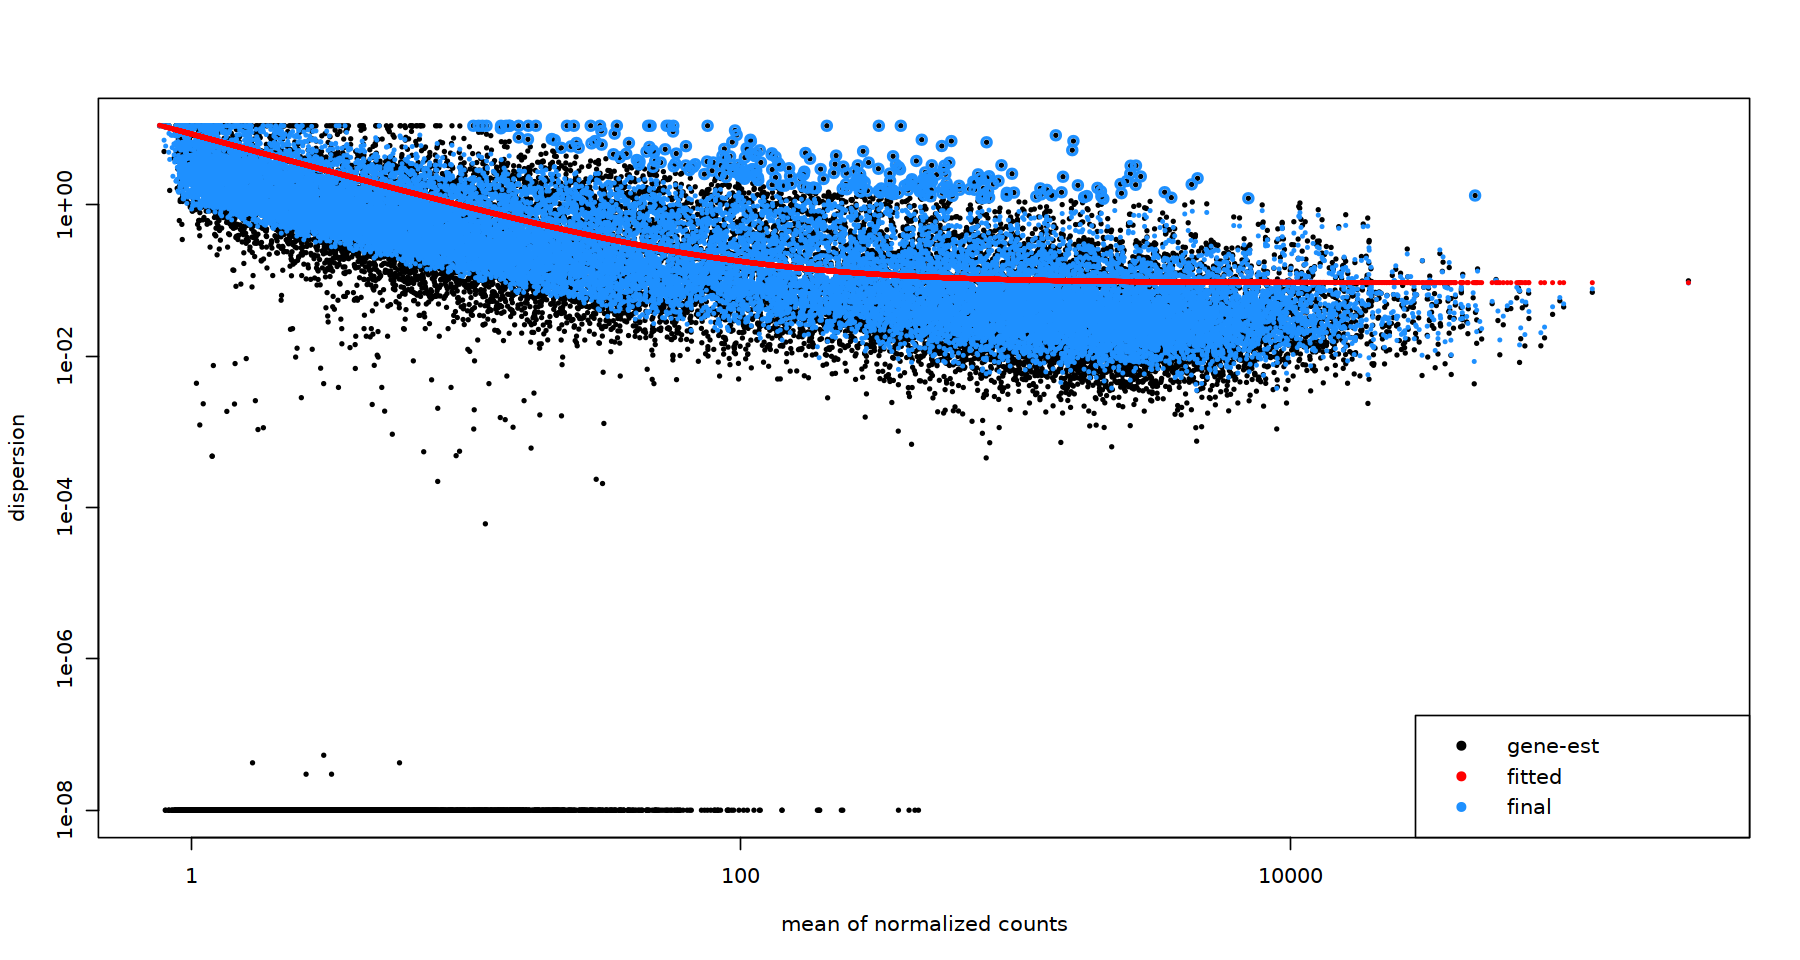

In [39]:
## Code cell 39 ##

plotDispEsts(dds2)

The plot here is as expected in a typical RNASeq data set where the dispersion increases when variance incraases, but it decreases when mean increases.

Given the small sample size of most RNASeq datasets, estimation of gene variation is difficult. DESeq2 will borrow information from other genes to generate better estimates. It assumes that genes with similat expression levels have a similar variannce. The red line corresponds to the fitted curve to gene-wise dispersion estimates. This curve facilitates the identification of DE genes when sample sizes are small. In blue is the estimated dispersion for each gene toward the predicted values by the curve.

- Now consider the **distribution of raw counts and normalized counts by DESeq()**:

In [40]:
## Code cell 40 ##

summary(counts(dds2)) # raw counts

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   :     0      Min.   :     0      Min.   :     0     
 1st Qu.:     5      1st Qu.:     4      1st Qu.:     4     
 Median :    70      Median :    60      Median :    50     
 Mean   :  1884      Mean   :  1471      Mean   :  1338     
 3rd Qu.:  1435      3rd Qu.:  1174      3rd Qu.:  1022     
 Max.   :380993      Max.   :294250      Max.   :460910     
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   :     0      Min.   :     0      Min.   :     0     
 1st Qu.:     4      1st Qu.:     3      1st Qu.:     3     
 Median :    56      Median :    51      Median :    55     
 Mean   :  1393      Mean   :  1549      Mean   :  1411     
 3rd Qu.:  1095      3rd Qu.:  1222      3rd Qu.:  1180     
 Max.   :465330      Max.   :254944      Max.   :212782     
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   :     0            Min.   :     0.0          Min.   :     0

In [41]:
## Code cell 41 ##

summary(counts(dds2, normalize = TRUE))# normalized counts

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   :     0.00   Min.   :     0.00   Min.   :     0.0   
 1st Qu.:     3.75   1st Qu.:     3.78   1st Qu.:     4.4   
 Median :    52.55   Median :    56.66   Median :    54.8   
 Mean   :  1414.72   Mean   :  1388.67   Mean   :  1466.0   
 3rd Qu.:  1077.27   3rd Qu.:  1109.11   3rd Qu.:  1120.5   
 Max.   :286014.88   Max.   :277867.35   Max.   :505068.8   
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   :     0.0    Min.   :     0.00   Min.   :     0.00  
 1st Qu.:     4.1    1st Qu.:     2.81   1st Qu.:     2.90  
 Median :    58.0    Median :    47.71   Median :    53.13  
 Mean   :  1443.5    Mean   :  1448.91   Mean   :  1363.32  
 3rd Qu.:  1134.7    3rd Qu.:  1143.09   3rd Qu.:  1140.44  
 Max.   :482180.1    Max.   :238480.35   Max.   :205561.76  
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   :     0.00         Min.   :     0.00         Min.   :     0

We can plot these distribution of read counts (with a log2 transformation) using a boxplot, to verify that the read counts have indeed not yet been normalized between samples, unless we use normalize = TRUE.

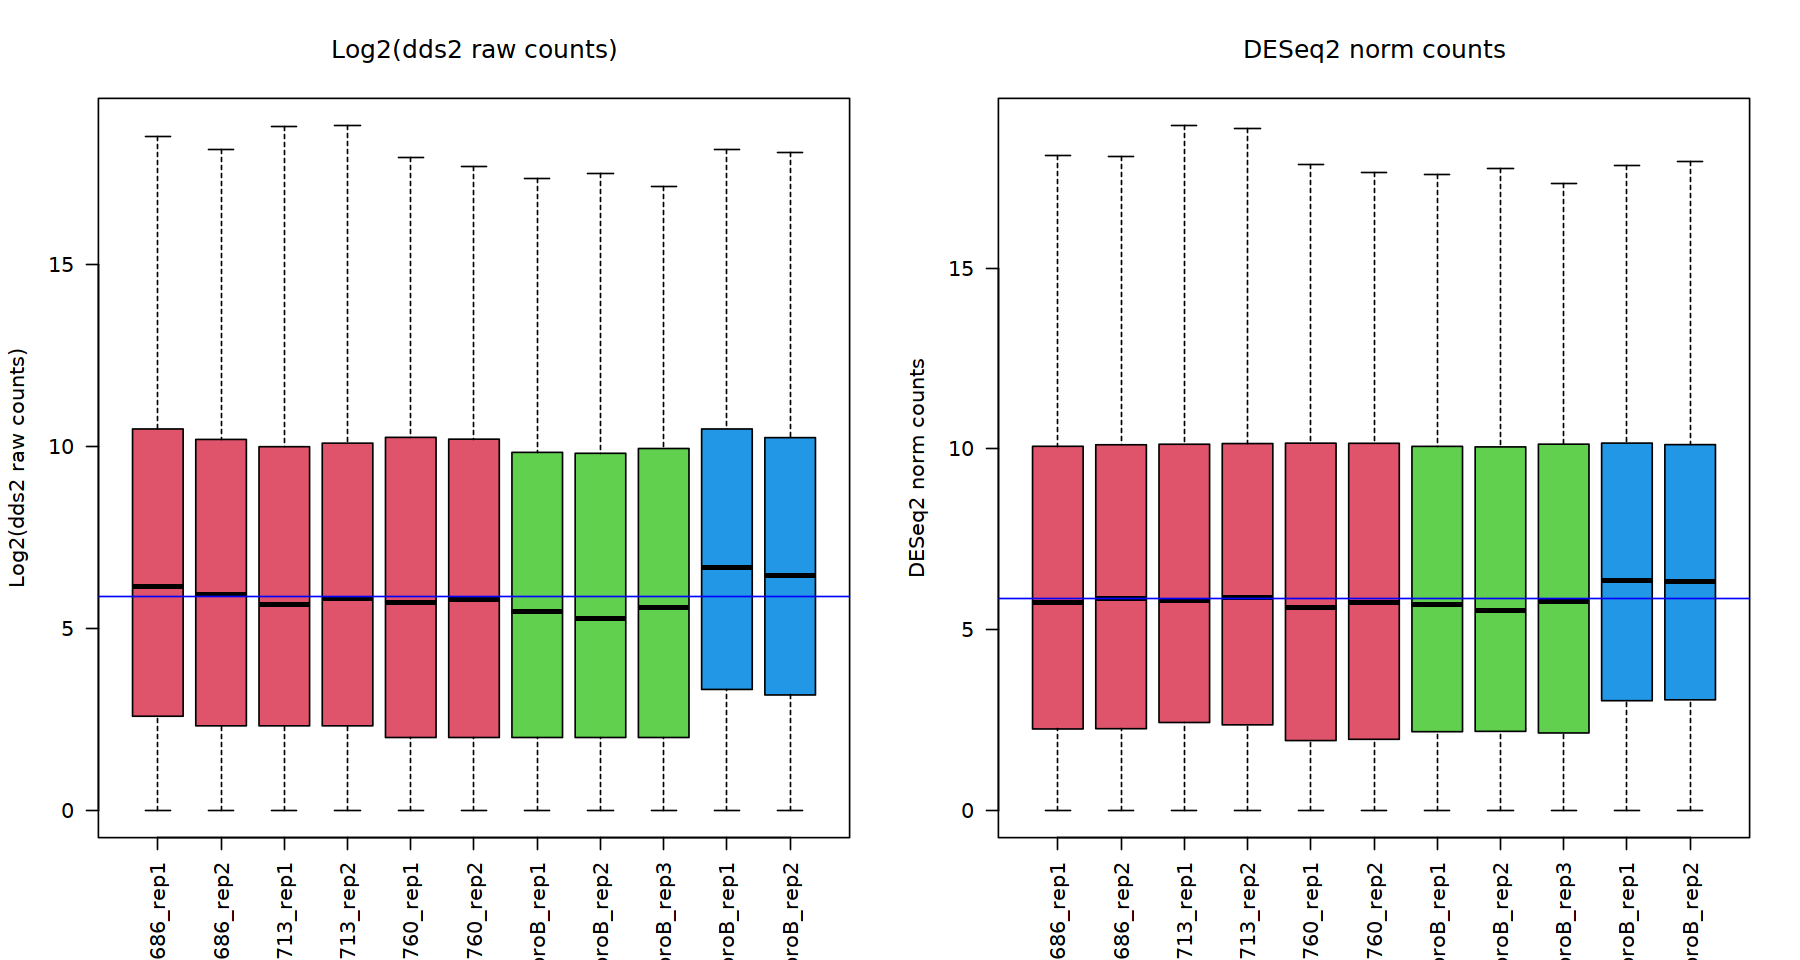

In [42]:
## Code cell 42 ##

# make a colour vector
#conditionColor <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# to display the two plots side by side
layout(matrix(1:2, ncol=2))

# Check distributions of samples using boxplots for the non-normalised data in log2
boxplot(log2(counts(dds2)+1), outline = FALSE,
        xlab="",
        ylab="Log2(dds2 raw counts)",
        las=2,
        col=conditionColor,
        main="Log2(dds2 raw counts)")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(log2(counts(dds2)+1)), col="blue")

# Check distributions of samples using boxplots
boxplot(log2(counts(dds2, normalize = TRUE)+1), outline = FALSE,
        xlab="",
        ylab="DESeq2 norm counts",
        las=2,
        col=conditionColor,
        main="DESeq2 norm counts")
# Let's add a blue horizontal line that corresponds to the median
abline(h = median(log2(counts(dds2, normalize = TRUE)+1)), col="blue")


As we can see, the log2 transformation gives a data distribution closer to the normal distribution, but does not perform well for normalizing data between samples.    

The main motive behind normalization is to change numeric values in a dataset to a common scale without distorting the differences between samples. This reduces the sparsity of the data as they are brought to a common close scale.


<div class="alert alert-block alert-danger"> <b> Caution on DESeq() norm counts: </b><br><ul> <li>For further exploratory analyses, it is not recommanded to use the normalised counts from DESeq() but one of the 2 other normalisation methods: <code>rlog</code>and <code>vst</code>. We will test the effect of both in part 3.<il>
    <li> For DE analysis, DESeq() norm counts must not be used since the linear model was already tested with the function. We will see in part 4 how to perform the DE analysis with the factor and contrats of interest.<il> </div>

---
---
## 3 - Normalization of the data with `rlog` or `vst` for vizualisation and further exploratory analyses
---

The following two methods of normalization implented in DESeq2 package are to be considered prior to exploratory analyses, like PCA, hierarchical clustering or heatmap, that will follow in the next pipeline.

### 3.1 - Data normalisation with `rlog`: Regularized-logarithm transformation
---

This function transforms the count data to the log2 scale in a way which minimizes differences between samples for rows with small counts, and which normalizes with respect to library size. For genes with high counts, rlog will not differ much from an ordinary log2 transformation.

> *In the function calls, we specified `blind = FALSE`, which means that differences between cell lines and treatment (the variables in the design) will not contribute to the expected variance-mean trend of the experiment. The experimental design is not used directly in the transformation, only in estimating the global amount of variability in the counts. For a fully **unsupervised** transformation, one can set `blind = TRUE` (which is the default).*   
[Love MI *et al.*, 2019](https://www.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#the-variance-stabilizing-transformation-and-the-rlog)

`blind=FALSE` greatly reduces the run time.

In [43]:
## Code cell 43 ##

rlog.dds2 <- rlog(dds2, blind = FALSE)
rlog.dds2

class: DESeqTransform 
dim: 22927 11 
metadata(1): version
assays(1): ''
rownames(22927): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00000095742.2 ENSMUSG00000095041.8
rowData names(27): baseMean baseVar ... maxCooks rlogIntercept
colnames(11): dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 ...
  wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
colData names(11): SampleID SampleName ... Tissue sizeFactor

Let's verify the effect by plotting the counts from `rlog.dds2`, side by side with the non-normalised data to see the effect of normalisation.

In [44]:
## Code cell 44 ##

# Get log2 counts
counts.rlog.dds2 <- assay(rlog.dds2)

summary(counts.rlog.dds2) # summary for each column

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   :-0.8689     Min.   :-0.8664     Min.   :-0.8645    
 1st Qu.: 2.1128     1st Qu.: 2.1083     1st Qu.: 2.1418    
 Median : 5.6650     Median : 5.7422     Median : 5.7107    
 Mean   : 6.0997     Mean   : 6.1250     Mean   : 6.1361    
 3rd Qu.:10.0772     3rd Qu.:10.1073     3rd Qu.:10.1159    
 Max.   :18.1101     Max.   :18.0739     Max.   :18.8260    
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   :-0.8652     Min.   :-0.8665     Min.   :-0.8661    
 1st Qu.: 2.1711     1st Qu.: 1.9846     1st Qu.: 2.0412    
 Median : 5.7555     Median : 5.5252     Median : 5.6648    
 Mean   : 6.1568     Mean   : 6.0664     Mean   : 6.0987    
 3rd Qu.:10.1271     3rd Qu.:10.1413     3rd Qu.:10.1340    
 Max.   :18.7675     Max.   :17.8827     Max.   :17.6974    
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   :-0.8603           Min.   :-0.8597           Min.   :-0.862

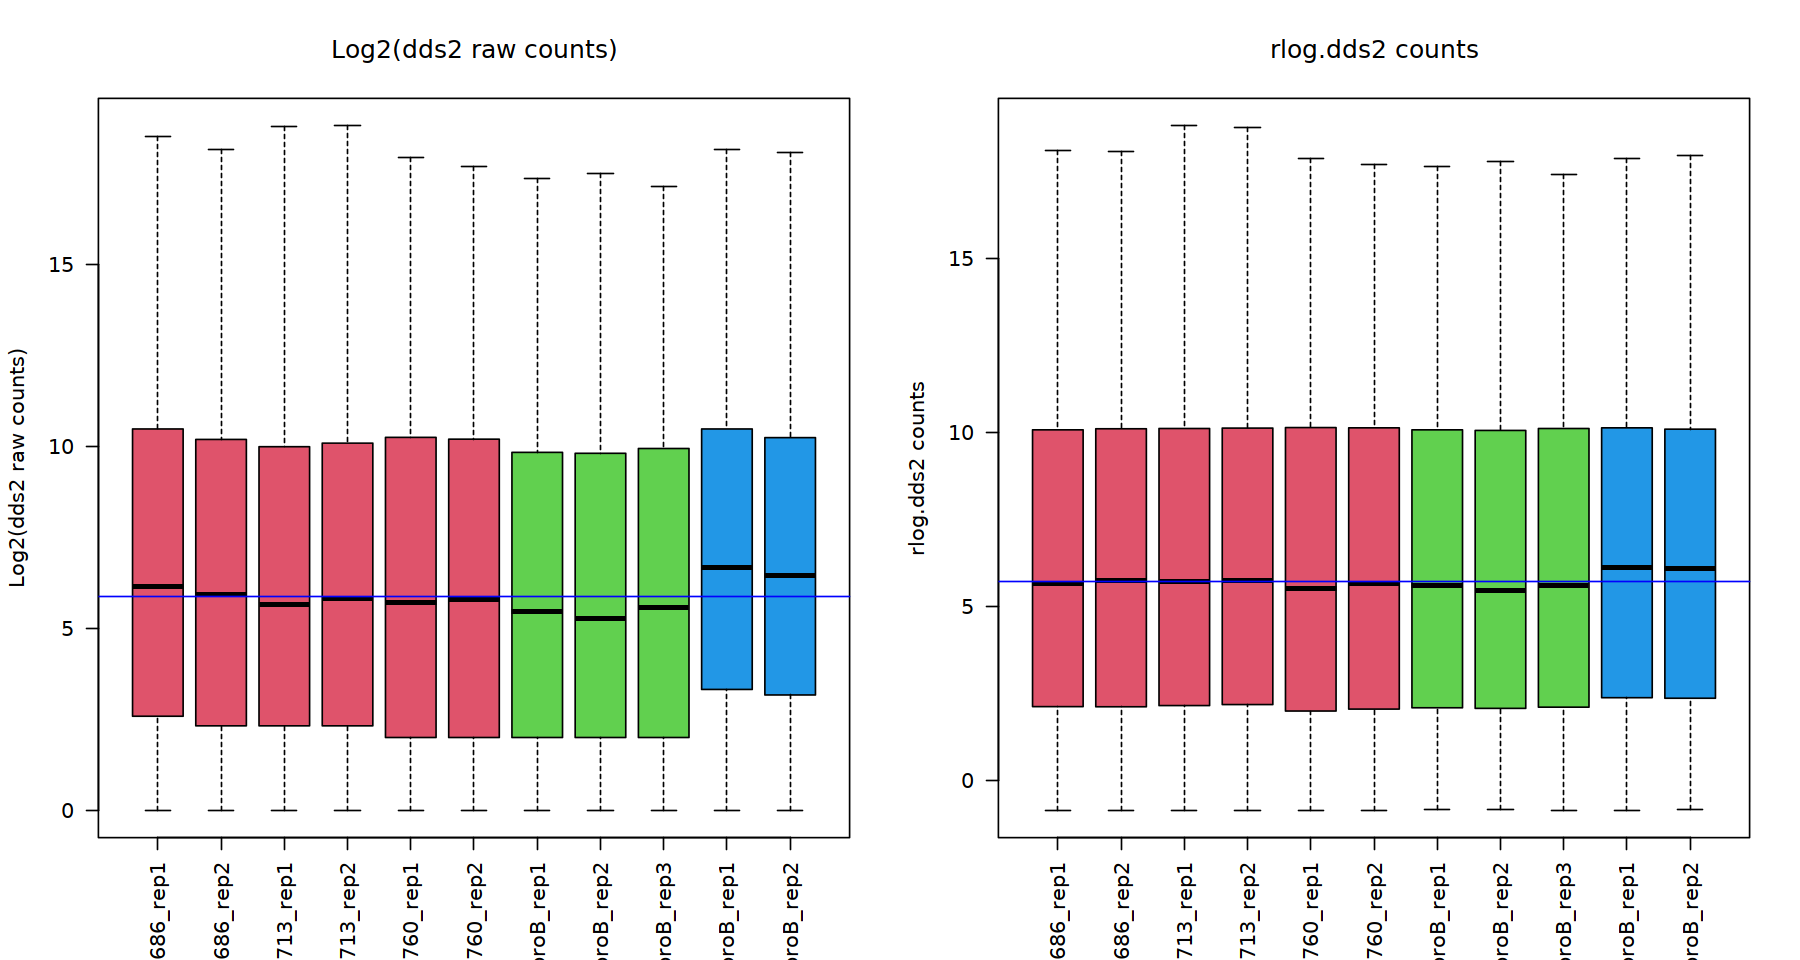

In [45]:
## Code cell 45 ##

# make a colour vector
#conditionColor <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# to display the two plots side by side
layout(matrix(1:2, ncol=2))

# Check distributions of samples using boxplots for the non-normalised data in log2
boxplot(log2(counts(dds2)+1), outline = FALSE,
        xlab="",
        ylab="Log2(dds2 raw counts)",
        las=2,
        col=conditionColor,
        main="Log2(dds2 raw counts)")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(log2(counts(dds2)+1)), col="blue")

# Check distributions of samples using boxplots for the rlog normalised data
boxplot(counts.rlog.dds2,
        xlab="",
        ylab="rlog.dds2 counts",
        las=2,
        col=conditionColor,
        main="rlog.dds2 counts")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(counts.rlog.dds2), col="blue")

We can also verify that the variance is not correlated any more to the average level of expression, by plotting standard deviation vs mean expression:

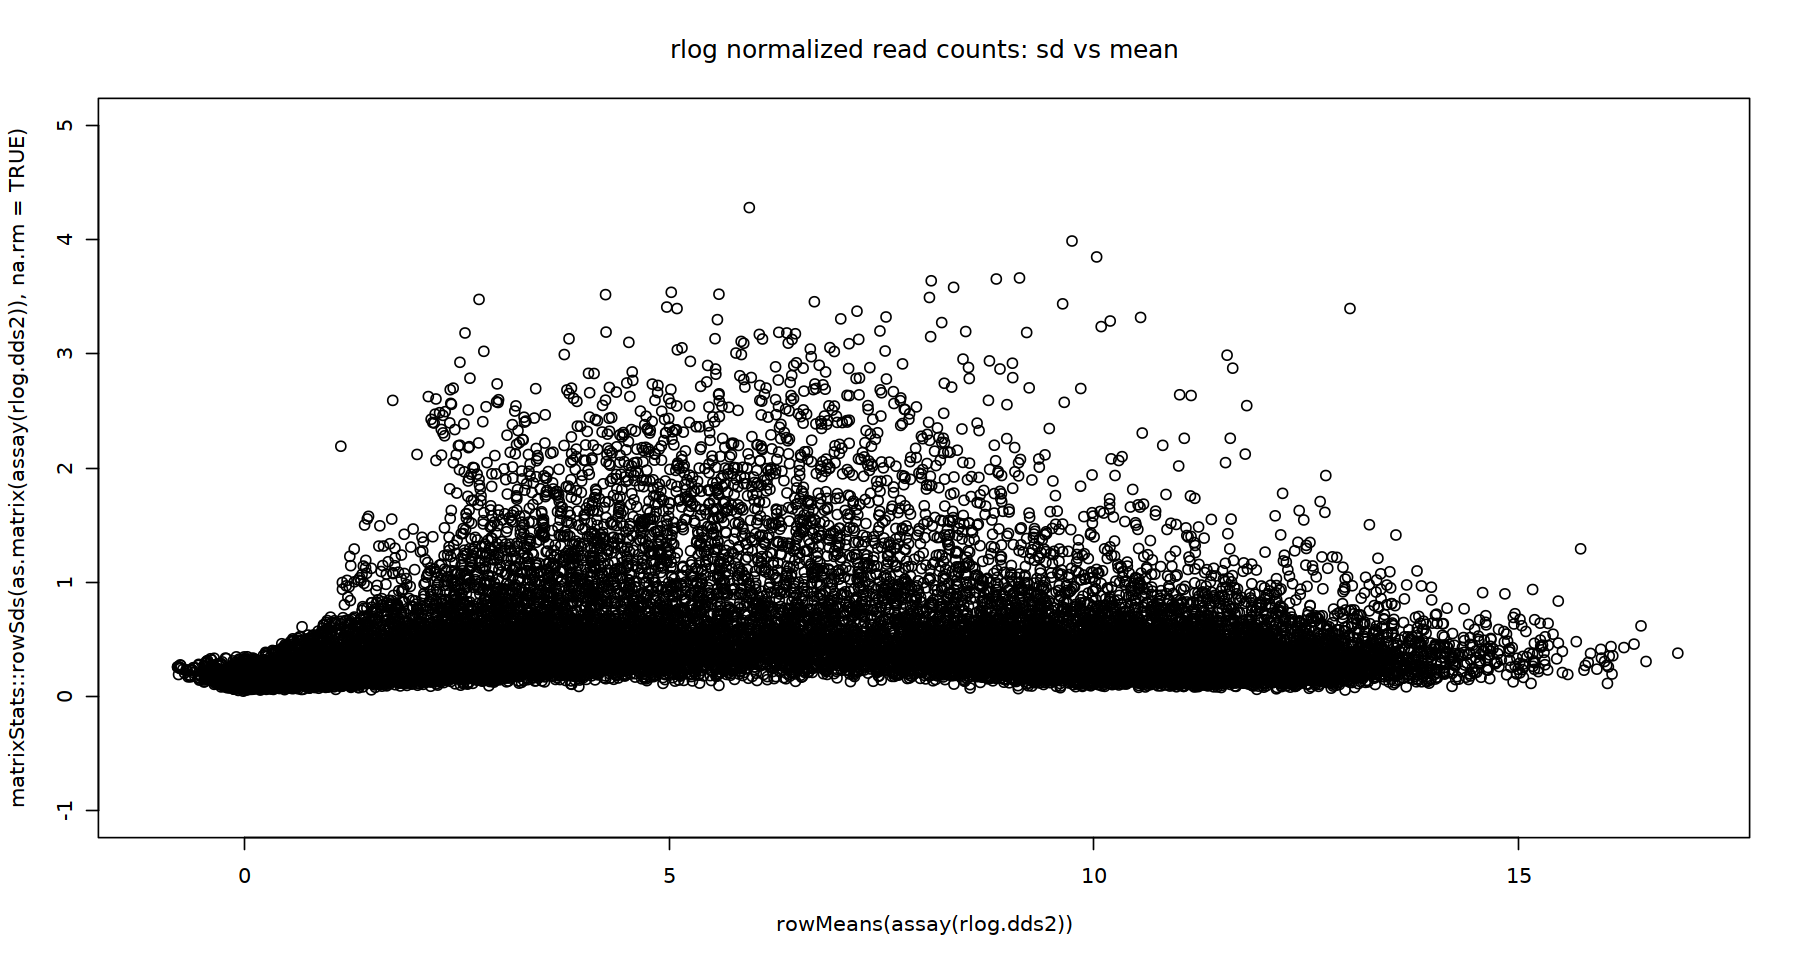

In [46]:
## Code cell 46 ##

# Raw counts mean expression Vs standard Deviation (SD)
plot(rowMeans(assay(rlog.dds2)), matrixStats::rowSds(as.matrix(assay(rlog.dds2)), na.rm=TRUE), 
     main='rlog normalized read counts: sd vs mean', 
     xlim=c(-1,17),
     ylim=c(-1,5))

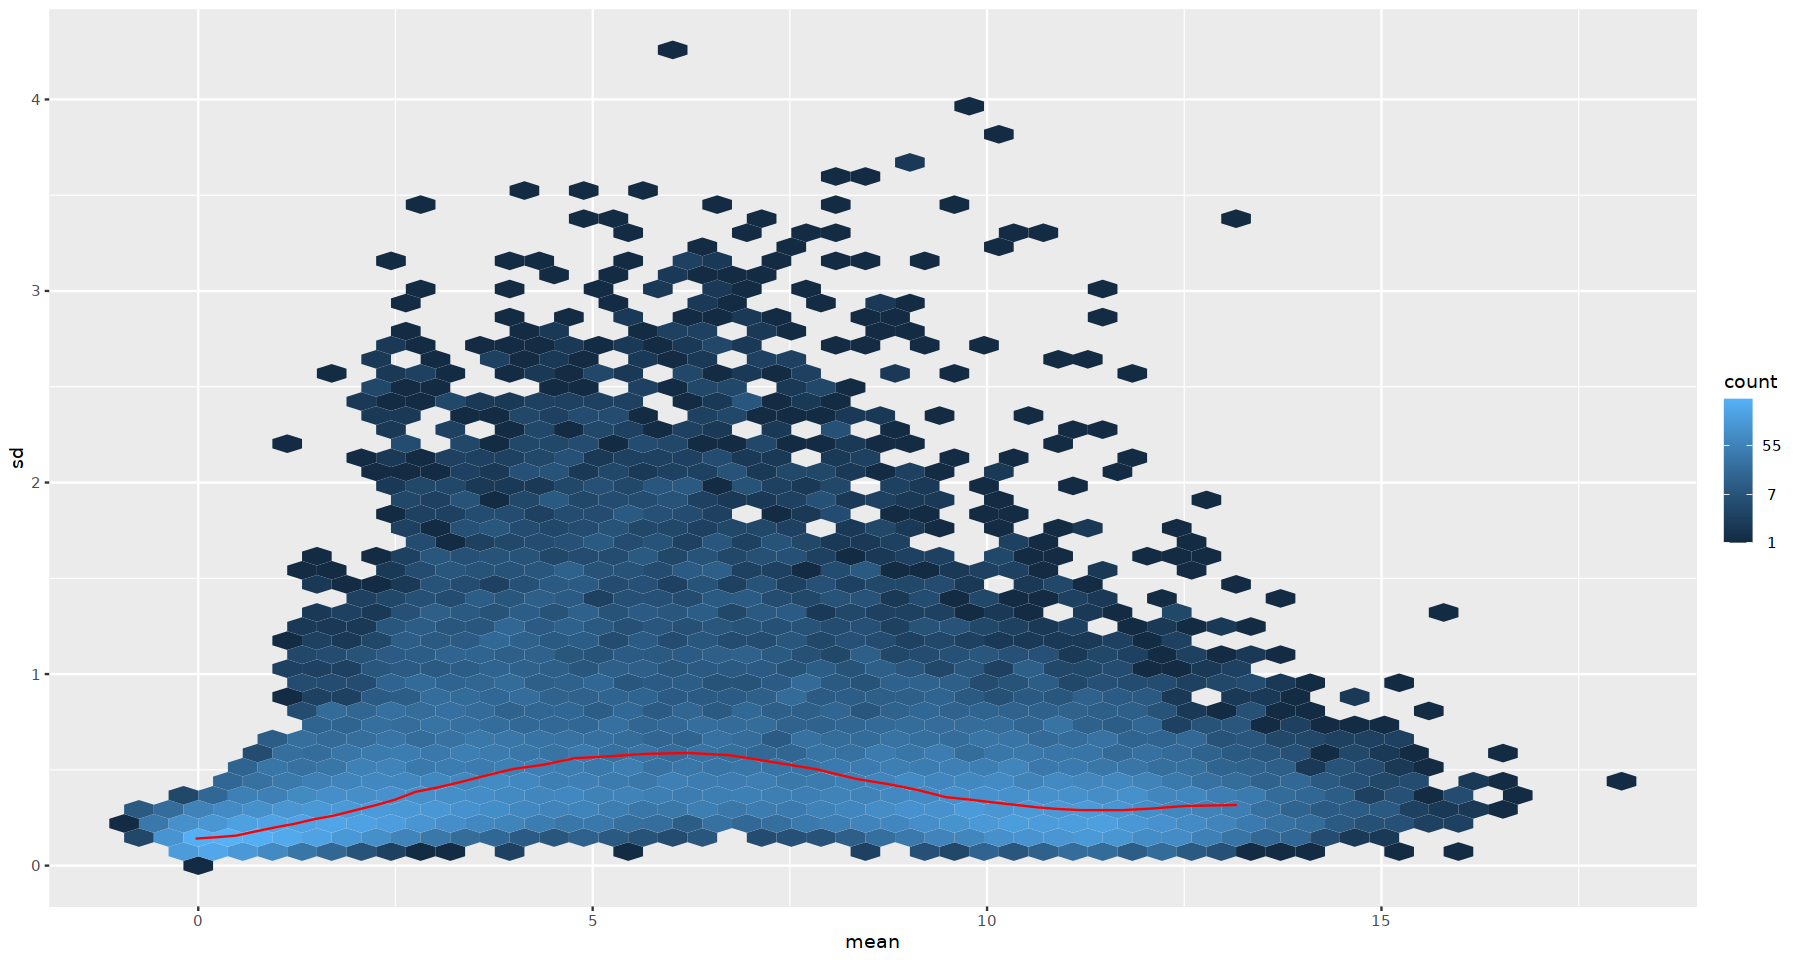

In [47]:
## Code cell 47 ##

vsn::meanSdPlot(assay(rlog.dds2), ranks=FALSE)

### 3.2 - Normalization with `vst`: variance stabilizing transformation
---

Variance stabilizing transformation (VST) aims at generating a matrix of values for which variance is constant across the range of mean values, especially for low mean.

The vst function computes the fitted dispersion-mean relation, derives the transformation to apply and accounts for library size.

In [48]:
## Code cell 48 ##

vst.dds2 <- vst(dds2, blind = FALSE)
vst.dds2

class: DESeqTransform 
dim: 22927 11 
metadata(1): version
assays(1): ''
rownames(22927): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00000095742.2 ENSMUSG00000095041.8
rowData names(26): baseMean baseVar ... maxCooks dispFit
colnames(11): dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 ...
  wt_BoneMar_proB_rep1 wt_BoneMar_proB_rep2
colData names(11): SampleID SampleName ... Tissue sizeFactor

Again, we check the effect by looking at summaries and plotting the log2 counts from `vst.dds2`

In [49]:
## Code cell 49 ##

# Get log2 counts
counts.vst.dds2 <- assay(vst.dds2)

summary(counts.vst.dds2) # summary for each column

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   : 5.994      Min.   : 5.994      Min.   : 5.994     
 1st Qu.: 6.343      1st Qu.: 6.344      1st Qu.: 6.371     
 Median : 7.263      Median : 7.308      Median : 7.288     
 Mean   : 8.344      Mean   : 8.357      Mean   : 8.366     
 3rd Qu.:10.230      3rd Qu.:10.268      3rd Qu.:10.282     
 Max.   :18.126      Max.   :18.085      Max.   :18.946     
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   : 5.994      Min.   : 5.994      Min.   : 5.994     
 1st Qu.: 6.361      1st Qu.: 6.296      1st Qu.: 6.301     
 Median : 7.323      Median : 7.206      Median : 7.269     
 Mean   : 8.381      Mean   : 8.335      Mean   : 8.349     
 3rd Qu.:10.298      3rd Qu.:10.308      3rd Qu.:10.305     
 Max.   :18.880      Max.   :17.864      Max.   :17.650     
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   : 5.994            Min.   : 5.994            Min.   : 5.994

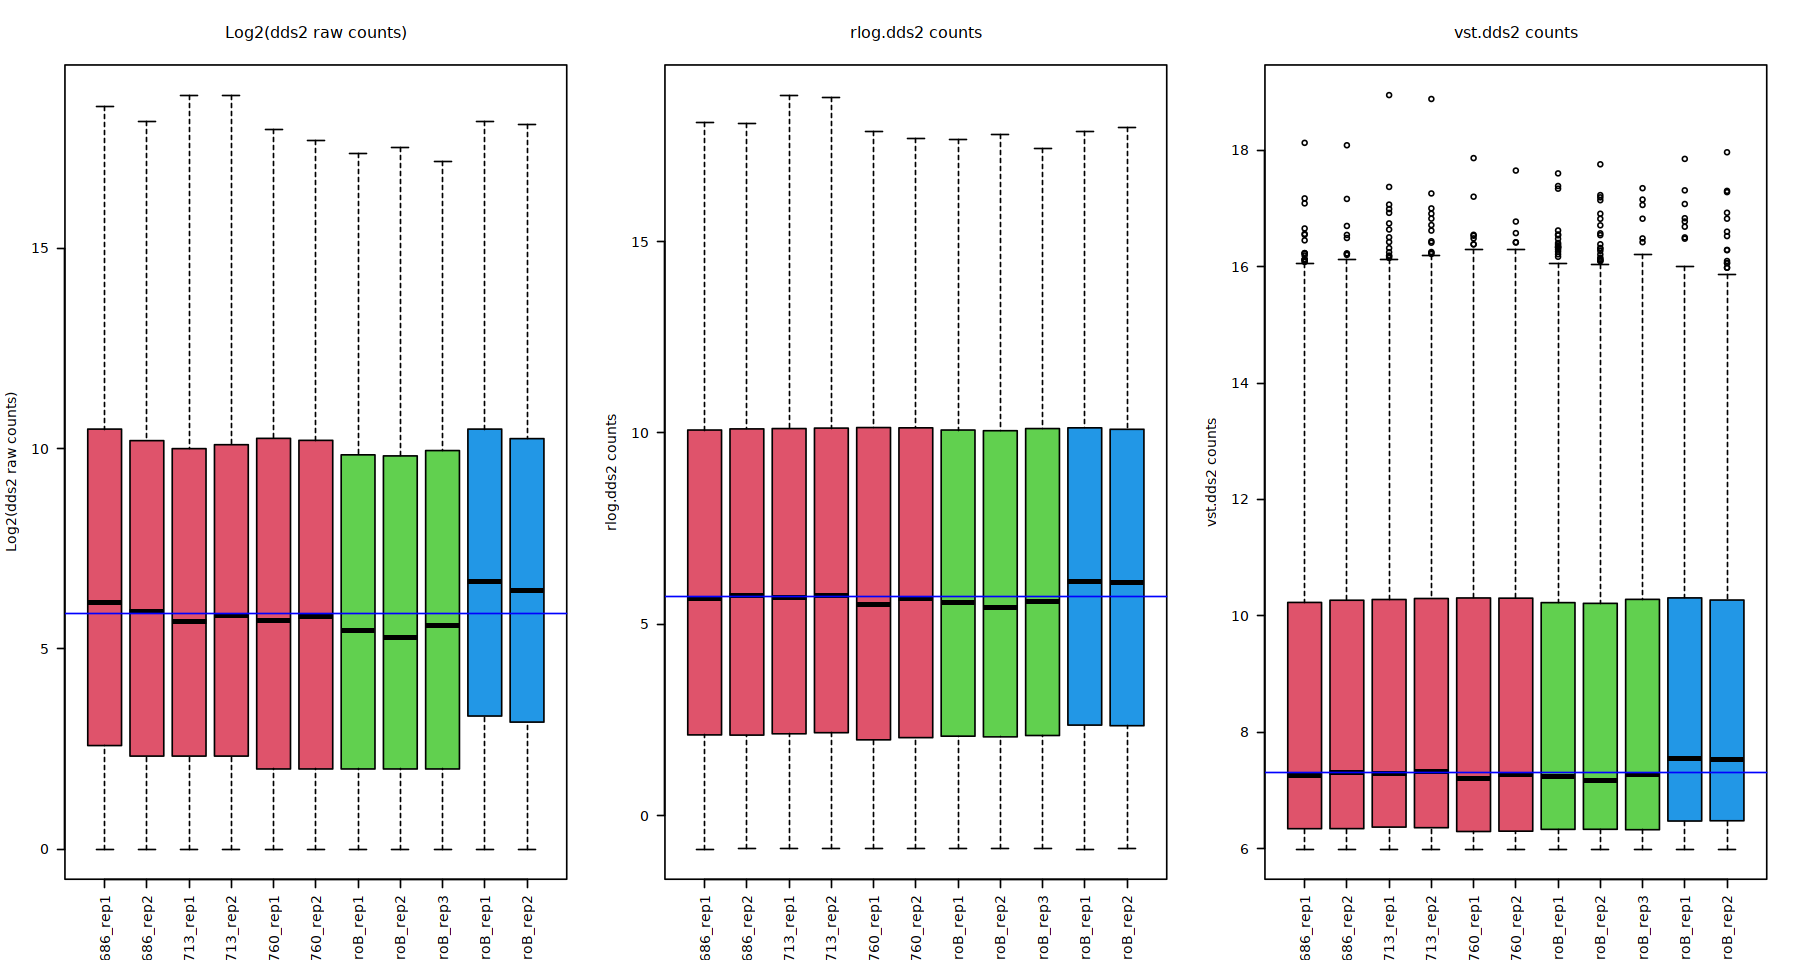

In [50]:
## Code cell 50 ##

# make a colour vector
#conditionColor <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# to display the two plots side by side
layout(matrix(1:3, ncol=3))


# Check distributions of samples using boxplots for the non-normalised data in log2
boxplot(log2(counts(dds2)+1), outline = FALSE,
        xlab="",
        ylab="Log2(dds2 raw counts)",
        las=2,
        col=conditionColor,
        main="Log2(dds2 raw counts)")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(log2(counts(dds2)+1)), col="blue")

# Check distributions of samples using boxplots for the rlog normalised data
boxplot(counts.rlog.dds2,
        xlab="",
        ylab="rlog.dds2 counts",
        las=2,
        col=conditionColor,
        main="rlog.dds2 counts")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(counts.rlog.dds2), col="blue")

# Check distributions of samples using boxplots
boxplot(counts.vst.dds2,
        xlab="",
        ylab="vst.dds2 counts",
        las=2,
        col=conditionColor,
        main="vst.dds2 counts")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(counts.vst.dds2), col="blue")

We also verify the decoupling of variance and mean level of expression:

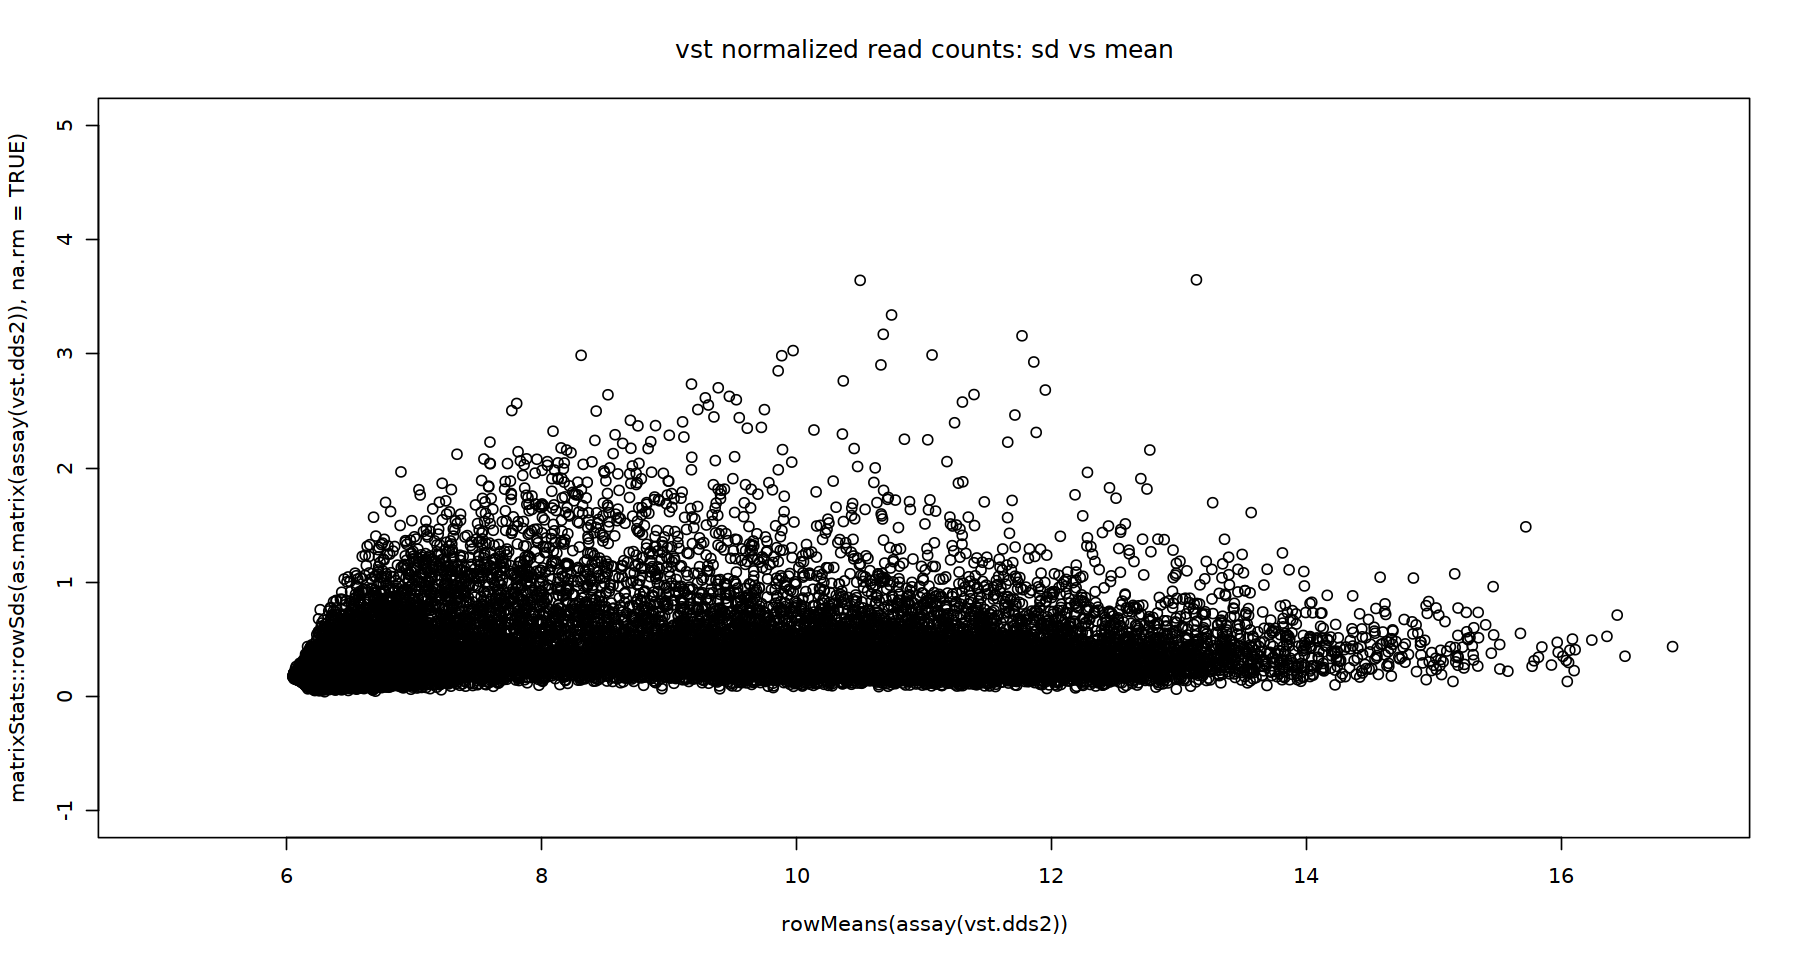

In [51]:
## Code cell 51 ##

# Raw counts mean expression Vs standard Deviation (SD)
plot(rowMeans(assay(vst.dds2)), matrixStats::rowSds(as.matrix(assay(vst.dds2)), na.rm = TRUE), 
     main = 'vst normalized read counts: sd vs mean', 
     xlim = c(5,17),
     ylim = c(-1,5))

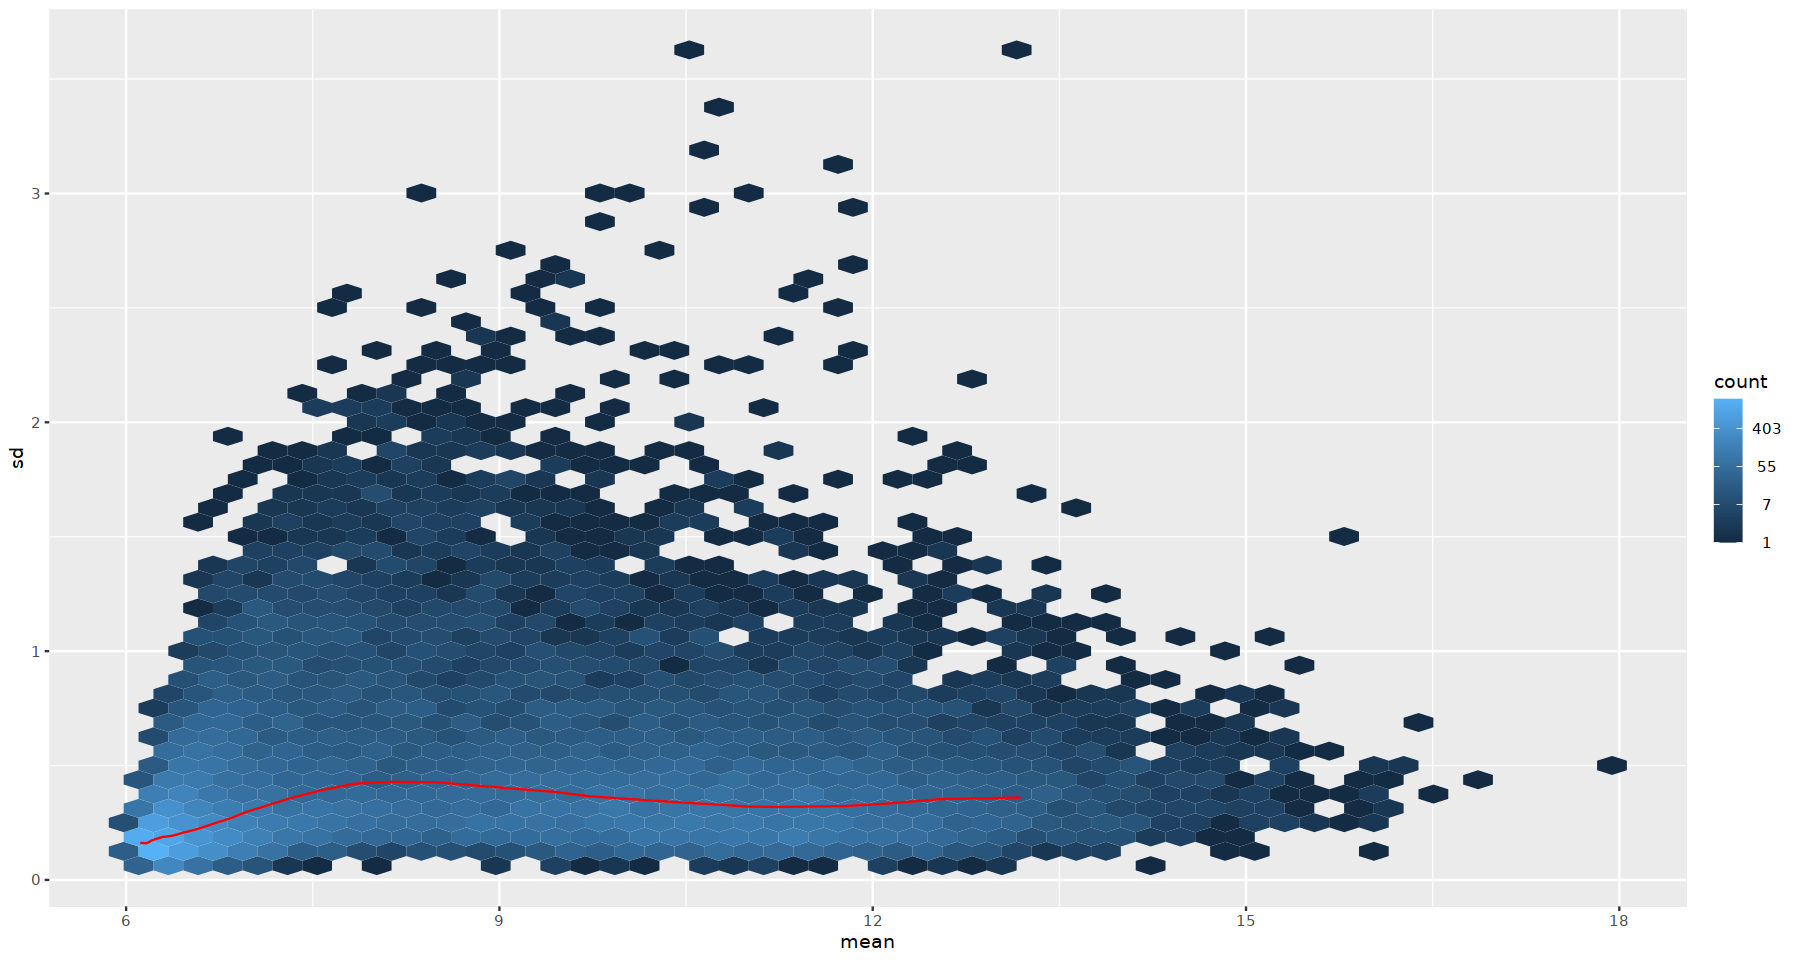

In [52]:
## Code cell 52 ##

vsn::meanSdPlot(assay(vst.dds2), ranks=FALSE)


We can also display the scatterplot of transformed counts from two samples:

Warning message:
“`as_data_frame()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


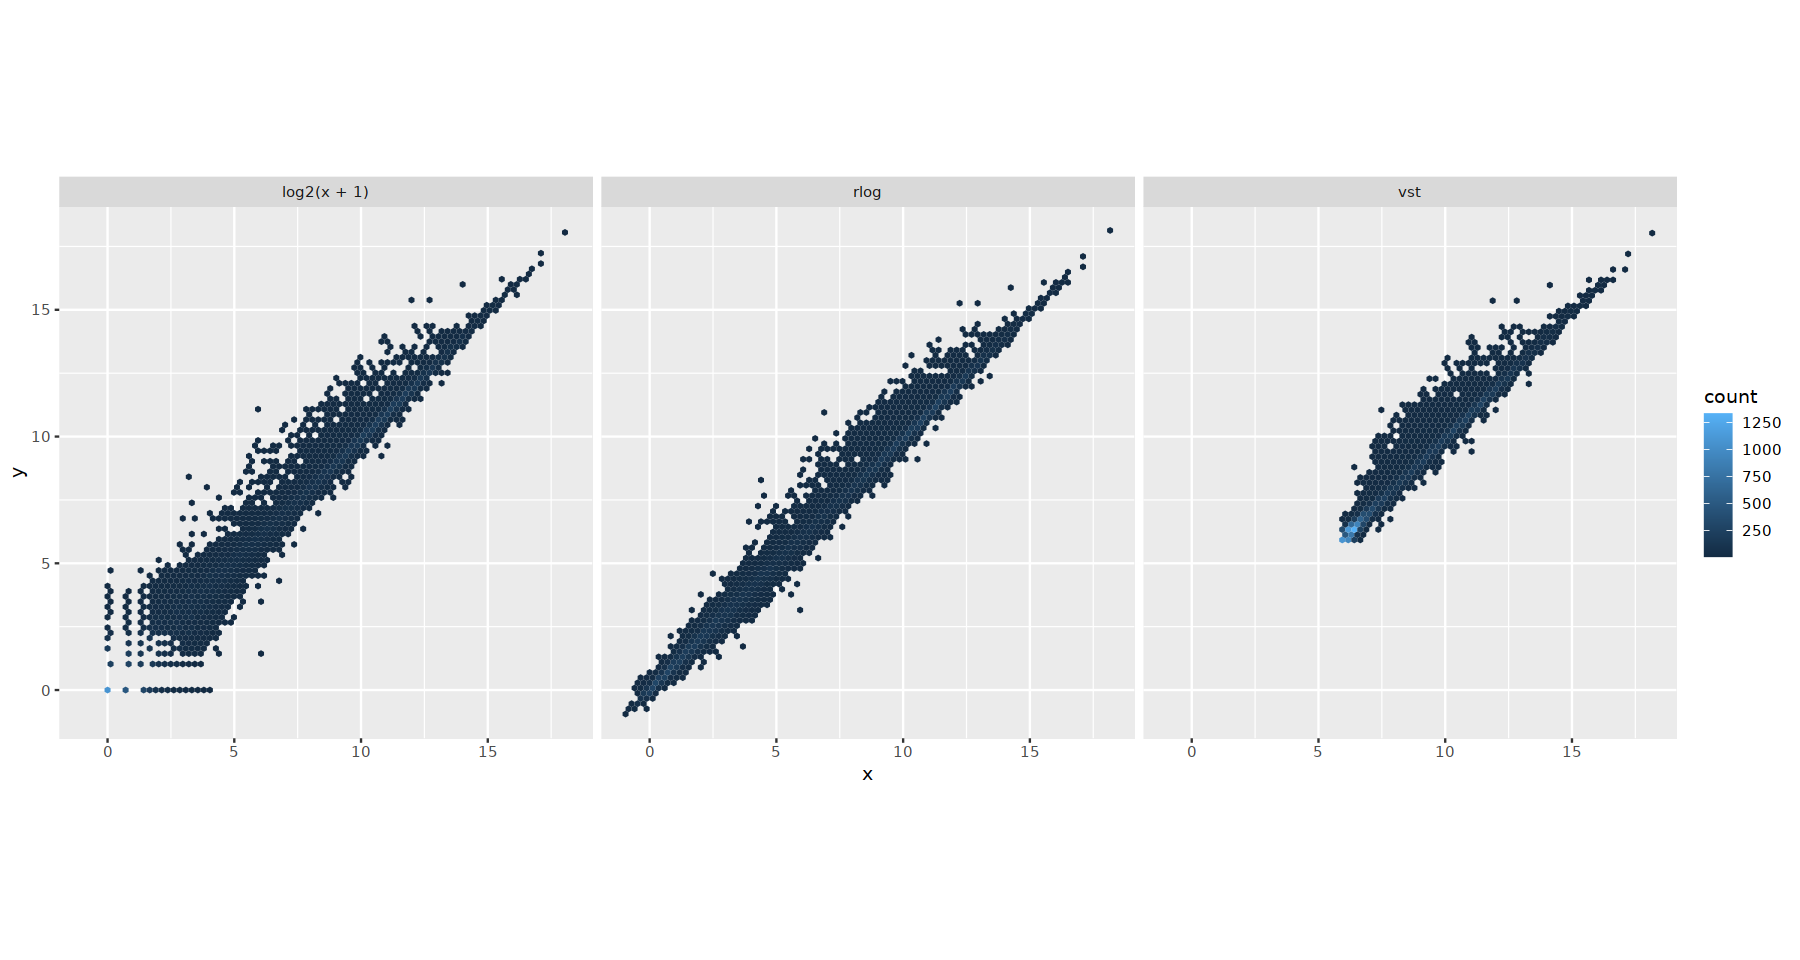

In [53]:
## Code cell 53 ##

df <- bind_rows(
  as_data_frame(log2(counts(dds2, normalized=TRUE)[, 1:2]+1)) %>%
         mutate(transformation = "log2(x + 1)"),
  as_data_frame(assay(rlog.dds2)[, 1:2]) %>% mutate(transformation = "rlog"),
  as_data_frame(assay(vst.dds2)[, 1:2]) %>% mutate(transformation = "vst"))
  
colnames(df)[1:2] <- c("x", "y")  

lvls <- c("log2(x + 1)", "rlog", "vst")
df$transformation <- factor(df$transformation, levels=lvls)

ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

### 3.3- Choosing the best transformation for our data for further exploratory analyses
---

You can see that both methods worked on our data, even if the output are different.   
    
The indications to guide the choice between the two methods are:

> *For genes with high counts, both the VST and the rlog will give similar result to the ordinary log2 transformation of normalized counts. For genes with lower counts, however, the values are shrunken towards a middle value. The VST or rlog-transformed data then become approximately homoskedastic (more flat trend in the meanSdPlot), and can be used directly for computing distances between samples, making PCA plots, or as input to downstream methods which perform best with homoskedastic data.  
> **Which transformation to choose?** The VST is much faster to compute and is less sensitive to high count outliers than the rlog. The rlog tends to work well on small datasets (n < 30), potentially outperforming the VST when there is a wide range of sequencing depth across samples (an order of magnitude difference). We therefore recommend the VST for medium-to-large datasets (n > 30). You can perform both transformations and compare the meanSdPlot or PCA plots generated, as described below.*  
[Love MI *et al.*, 2019](https://www.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#the-variance-stabilizing-transformation-and-the-rlog)

Both tranformation methods performed well on our dataset, but we can notice that, in the rlog normalisation, the distribution appear more centered on the median for each sample, and the variance seems less related to the mean level of expression, especially for low values. Furthermore, there are still some outliers for the vst nomalisation.  

Thus, we will keep the **rlog** transformation to go on with the the second exploratory analysis in the next notebook.

In [54]:
## Code cell 54 ##

head(assay(rlog.dds2))

,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,wt_BoneMar_proB_rep1,wt_BoneMar_proB_rep2
ENSMUSG00000025902.14,2.2753837,1.7844995,5.2884251,5.0785500,5.8854530,6.2842913,1.8848576,1.8888486,1.8702935,1.7061761,2.0175685
ENSMUSG00000104238.2,-0.4808090,-0.4777344,-0.4754620,-0.4763427,-0.2539682,0.3804070,-0.4743753,-0.4742319,-0.4748919,-0.4800467,-0.4781996
ENSMUSG00000102269.2,0.9905249,1.1021238,0.9850394,0.7932449,0.9593785,1.1077793,0.9965492,0.9023834,0.8981402,0.9360354,0.9558681
ENSMUSG00000098104.2,7.2186175,7.2854975,7.6275423,7.4973094,7.5511432,7.2601744,7.9467515,7.1022852,7.5134550,7.6407675,7.5860592
ENSMUSG00000102175.2,0.2090871,0.3782832,0.3123558,0.5374955,0.2114604,0.3816452,0.2143432,0.2144627,0.4068486,0.4187628,0.2961543
ENSMUSG00000103922.2,5.4879658,5.6120498,5.6262906,5.3522473,5.7958246,5.1590202,5.1587966,4.9124878,5.1621085,5.4650184,5.4700902


Before saving the rlog counts for further analysis, we will merge this data with the gene info stored in gencode dataframe in order to have gene names in addition to Ensembl IDs. 

In the `merge()` function, we specify both dataframes, followed by `by.x = 0` to indicate the `gene_id` key is present in the row names of the first dataframe.

In [55]:
## Code cell 55 ##

rlog.dds2.annot <- merge(as.data.frame(assay(rlog.dds2)),
                gencode,
                by.x = 0, by.y = "gene_id",
                all.x = T, sort = F)
names(rlog.dds2.annot)[1] <- "ensemblID"

In [56]:
## Code cell 56 ##

head(rlog.dds2.annot)

,ensemblID,dHet_B-ALL_686_rep1,dHet_B-ALL_686_rep2,dHet_B-ALL_713_rep1,dHet_B-ALL_713_rep2,dHet_B-ALL_760_rep1,dHet_B-ALL_760_rep2,dHet_FetalLiver_proB_rep1,dHet_FetalLiver_proB_rep2,dHet_FetalLiver_proB_rep3,⋯,chr,annotation,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000025902.14,2.2753837,1.7844995,5.2884251,5.0785500,5.8854530,6.2842913,1.8848576,1.8888486,1.8702935,⋯,chr1,HAVANA,4561154,4567577,-,protein_coding,Sox17,level 2,MGI:107543,OTTMUSG00000050014.7
2,ENSMUSG00000104238.2,-0.4808090,-0.4777344,-0.4754620,-0.4763427,-0.2539682,0.3804070,-0.4743753,-0.4742319,-0.4748919,⋯,chr1,HAVANA,4566774,4569781,+,lncRNA,Gm37587,level 2,MGI:5610815,OTTMUSG00000050024.2
3,ENSMUSG00000102269.2,0.9905249,1.1021238,0.9850394,0.7932449,0.9593785,1.1077793,0.9965492,0.9023834,0.8981402,⋯,chr1,HAVANA,4593128,4596960,+,processed_pseudogene,Gm7357,level 2,MGI:3643257,OTTMUSG00000050025.1
4,ENSMUSG00000098104.2,7.2186175,7.2854975,7.6275423,7.4973094,7.5511432,7.2601744,7.9467515,7.1022852,7.5134550,⋯,chr1,HAVANA,4758157,4759626,-,processed_pseudogene,Gm6085,level 2,MGI:3646770,OTTMUSG00000043092.1
5,ENSMUSG00000102175.2,0.2090871,0.3782832,0.3123558,0.5374955,0.2114604,0.3816452,0.2143432,0.2144627,0.4068486,⋯,chr1,HAVANA,4762442,4763647,-,processed_pseudogene,Gm6119,level 2,MGI:3644547,OTTMUSG00000050009.1
6,ENSMUSG00000103922.2,5.4879658,5.6120498,5.6262906,5.3522473,5.7958246,5.1590202,5.1587966,4.9124878,5.1621085,⋯,chr1,HAVANA,4841354,4842422,+,processed_pseudogene,Gm6123,level 2,MGI:3647047,OTTMUSG00000050042.1


---
---
## 4 - Differential expression analysis with `DESeq2`
---

Differential expression analysis is classically the main way to analyse expression data from a quantitative point of view.   
This approach relies on statistical tests to identify the genes that present a level of expression that is significantly different  from one condition to another, or between several conditions.  
The genes are therefore considered as Differentially Expressed, and you'll often see the abreviation *DE genes*.   

To identify those DE genes, we need to:
- define the comparison(s) that we want to perform, by building a *contrast*
- run the analysis of expression data using this constrast. 

Tools such as `DESeq2` will :
- take into account the contrast to define the groups to compare, 
- compute the within-group and the between-group variability, 
- run a statistical test on each gene to look for statistically-significant differences of expression, 
- correct the resulting p-value to account for multiple testing
- return the list of genes with an adjusted p-value below a given threshold

### 4.1 - Building the results table
---

The `results` table is a dataframe that contains our differentially expressed genes, their p-values, whether the genes are upregulated or downregulated, the number of outliers, etc.  

`summary()` gives us the genes that are up and down regulated in our condition under study, as well as low count genes and outliers. This generates summary tarries for the data. You can read about more about the results function by looking up `?results`

* **Choose the comparison to perform**

We begin by defining the contrast, that is the comparison that we want to perform.  
When geneating dds2, we specified the WT group as a reference. We can see that the current model design will test the contrats between either dHet or dHetRag versus the WT group.

In [57]:
## Code cell 57 ##

resultsNames(dds2)

[1] "Intercept"               "Condition_dHet_vs_WT"   
[3] "Condition_dHetRag_vs_WT"

We always can define new contrats.

  
Here we choose to compare **the ALL leukemic cells to the dHet-Rag non leukemic ones**: 

In [58]:
## Code cell 58 ##

dHet_dHetRag <- c("Condition", "dHet", "dHetRag")

* **Perform the comparison between groups**

Now we can run `DESeq2` for this comparison. It will not work on the normalised rlog.dds2, but on the not-yet normalised dds2 : indeed the normalisation step has to take into account the inter-group variability, and the intra-group variability to be correct, meaning that... the groups have to be defined first!   
Now that `DESeq2` knows which groups we want to compare, thanks to the `contrast` defined above, it will run the normalisation on the fly, and identify the genes that are significantly differentially expressed (DE genes) according to that specific normalisation.  

In [59]:
## Code cell 59 ##

res_dHet_dHetRag <- results(dds2, contrast = dHet_dHetRag)
summary(res_dHet_dHetRag)


out of 22927 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4714, 21%
LFC < 0 (down)     : 3710, 16%
outliers [1]       : 29, 0.13%
low counts [2]     : 1778, 7.8%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Here, we found very few outliers, and we have 7.8% of low counts genes.   
The threshold used to consider a gene as significantly differentially expressed is a adjusted p-value of 0.1. Adjusted p-value means that a correction has been performed on the raw p-value, to take into consideration that the statistical test have been reiterated many times, as many as the number of genes. On such a high number of tests, numerous will give a "significant result" only by chance.   
The most-commonly used p-value correction is the **Benjamini-Hochberg method**, it is the one used by default by `DESeq2`. You could specify another one in the argument of the function.  

We obtain 4714 significantly up-regulated genes + 3710 significantly down-regulated genes. LFC stands for Log2 Fold Change, that is the ratio of the expression of a given gene in the test conditon on its expression in the Reference condition, in log2 scale. Therefore, a log2 FC of 1 means that the gene is 2-times more expressed in the test samples versus the reference samples.

*For information, if we run the comparison between `dHet`and `WT` cells, we obtain:*    
    out of 22927 with nonzero total read count   
    adjusted p-value < 0.1   
    LFC > 0 (up)       : 3309, 14%   
    LFC < 0 (down)     : 3542, 15%   
    outliers [1]       : 29, 0.13%   
    low counts [2]     : 2223, 9.7%   
    (mean count < 2)   
    [1] see 'cooksCutoff' argument of ?results   
    [2] see 'independentFiltering' argument of ?results

### 4.2 - Working with a different threshold: alpha 0.05

By default, the result function uses an adjusted p-value (FDR) cutoff of 0.1. If any other p value is prefered, `alpha` should be set to that value, as shown below where we set `alpha=0.05`.

In [60]:
## Code cell 60 ##

res2_dHet_dHetRag <- results(dds2, contrast = dHet_dHetRag,  alpha = 0.05)
summary(res2_dHet_dHetRag)


out of 22927 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4044, 18%
LFC < 0 (down)     : 3096, 14%
outliers [1]       : 29, 0.13%
low counts [2]     : 2223, 9.7%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



We can now count the number of differentially expressed genes with adjusted p-values were less than 0.05. na.rm=TRUE removes any row with missing information.

In [61]:
## Code cell 61 ##

sum(res2_dHet_dHetRag$padj < 0.05, na.rm = TRUE)
summary(res2_dHet_dHetRag)
# 7140

[1] 7140


out of 22927 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4044, 18%
LFC < 0 (down)     : 3096, 14%
outliers [1]       : 29, 0.13%
low counts [2]     : 2223, 9.7%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



So out of the 22927 filtered genes, 7140 have adjusted p-values below 0.05, with 4044 significantly up-regulated genes + 3096 significantly down-regulated genes. Let’s go ahead and select them.

In [62]:
## Code cell 62 ##

res2_dHet_dHetRag_sig_genes <- subset(res2_dHet_dHetRag, padj < 0.05)
dim(res2_dHet_dHetRag_sig_genes)

## 7140     6

[1] 7140    6

We then order the selected genes by the smallest p value:

In [63]:
## Code cell 63 ##

res2_dHet_dHetRag_sig_ranked <- res2_dHet_dHetRag_sig_genes[order(res2_dHet_dHetRag_sig_genes$pvalue),]
dim(res2_dHet_dHetRag_sig_ranked)
head(res2_dHet_dHetRag_sig_ranked)
## [1] 7140    6

[1] 7140    6

log2 fold change (MLE): Condition dHet vs dHetRag 
Wald test p-value: Condition dHet vs dHetRag 
DataFrame with 6 rows and 6 columns
                      baseMean log2FoldChange     lfcSE      stat       pvalue
                     <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSMUSG00000076621.2  1157.382       -9.14392  0.271972  -33.6209 8.30815e-248
ENSMUSG00000024241.8  5714.557        5.00660  0.207567   24.1203 1.52914e-128
ENSMUSG00000117613.3  1665.566        7.61270  0.336304   22.6363 1.90183e-113
ENSMUSG00000076618.2   317.744       -4.13226  0.186268  -22.1845 4.84963e-109
ENSMUSG00000076620.3   191.446       -5.93423  0.275753  -21.5201 1.01030e-102
ENSMUSG00000070348.6  5630.466        7.04781  0.347832   20.2621  2.77904e-91
                             padj
                        <numeric>
ENSMUSG00000076621.2 1.71771e-243
ENSMUSG00000024241.8 1.58075e-124
ENSMUSG00000117613.3 1.31068e-109
ENSMUSG00000076618.2 2.50665e-105
ENSMUSG00000076620.3  4.17759e-



As you can see above, our current list only contains Ensembl GeneID and no genes names. 

We will thus merge DE genes with the gene info stored in gencode dataframe.  We keep only the 7140 genes that were present in the DE results by using all.x = T.

In [64]:
## Code cell 64 ##

res2_dHet_dHetRag_sig_ranked_annot <- merge(as.data.frame(res2_dHet_dHetRag_sig_ranked), gencode, 
                                            by.x = 0, by.y = "gene_id",
                                            all.x = T, sort = F)

In [65]:
## Code cell 65 ##

str(res2_dHet_dHetRag_sig_ranked_annot)

'data.frame':	7140 obs. of  17 variables:
 $ Row.names     : 'AsIs' chr  "ENSMUSG00000076621.2" "ENSMUSG00000024241.8" "ENSMUSG00000117613.3" "ENSMUSG00000076618.2" ...
 $ baseMean      : num  1157 5715 1666 318 191 ...
 $ log2FoldChange: num  -9.14 5.01 7.61 -4.13 -5.93 ...
 $ lfcSE         : num  0.272 0.208 0.336 0.186 0.276 ...
 $ stat          : num  -33.6 24.1 22.6 -22.2 -21.5 ...
 $ pvalue        : num  8.31e-248 1.53e-128 1.90e-113 4.85e-109 1.01e-102 ...
 $ padj          : num  1.72e-243 1.58e-124 1.31e-109 2.51e-105 4.18e-99 ...
 $ chr           : chr  "chr12" "chr17" "chr18" "chr12" ...
 $ annotation    : chr  "HAVANA" "HAVANA" "HAVANA" "HAVANA" ...
 $ start         : num  1.13e+08 8.07e+07 1.53e+07 1.13e+08 1.13e+08 ...
 $ end           : num  1.13e+08 8.08e+07 1.54e+07 1.13e+08 1.13e+08 ...
 $ strand        : chr  "-" "-" "+" "-" ...
 $ gene_type     : chr  "IG_J_gene" "protein_coding" "lncRNA" "IG_J_gene" ...
 $ gene_name     : chr  "Ighj1" "Sos1" "Gm2629" "Ighj4" ...
 $ 

For further vizualization and analyses of the data, we may need to have the Ensembl gene ID as row names.

In [66]:
## Code cell 66 ##

names(res2_dHet_dHetRag_sig_ranked_annot)[1] <- "ensemblID"
head(res2_dHet_dHetRag_sig_ranked_annot, n = 20)

,ensemblID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr,annotation,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000076621.2,1157.3818,-9.143924,0.2719715,-33.62089,8.308155e-248,1.717711e-243,chr12,HAVANA,113393401,113393453,-,IG_J_gene,Ighj1,level 2,MGI:4439802,OTTMUSG00000051446.4
2,ENSMUSG00000024241.8,5714.5572,5.006601,0.2075675,24.12035,1.529138e-128,1.580746e-124,chr17,HAVANA,80701180,80787882,-,protein_coding,Sos1,level 2,MGI:98354,OTTMUSG00000072682.1
3,ENSMUSG00000117613.3,1665.5659,7.612699,0.3363043,22.63634,1.901833e-113,1.310680e-109,chr18,HAVANA,15327780,15409293,+,lncRNA,Gm2629,level 2,MGI:3780797,OTTMUSG00000072880.1
4,ENSMUSG00000076618.2,317.7437,-4.132263,0.1862682,-22.18448,4.849630e-109,2.506652e-105,chr12,HAVANA,113392134,113392187,-,IG_J_gene,Ighj4,level 2,MGI:4439658,OTTMUSG00000051493.3
5,ENSMUSG00000076620.3,191.4464,-5.934231,0.2757535,-21.52006,1.010300e-102,4.177589e-99,chr12,HAVANA,113393088,113393187,-,IG_J_gene,Ighj2,level 2,MGI:4439803,OTTMUSG00000051510.3
6,ENSMUSG00000070348.6,5630.4664,7.047812,0.3478324,20.26209,2.779041e-91,9.576111e-88,chr7,HAVANA,144483668,144493662,-,protein_coding,Ccnd1,level 2,MGI:88313,OTTMUSG00000026018.2
7,ENSMUSG00000084081.4,408.1937,-6.249222,0.3108017,-20.10678,6.436871e-90,1.901176e-86,chr11,HAVANA,22708599,22710025,-,processed_pseudogene,Gm12057,level 2,MGI:3650030,"tag overlapping_locus"""
8,ENSMUSG00000030172.16,267.6837,-5.463943,0.2841460,-19.22935,2.102439e-82,5.258264e-79,chr6,HAVANA,119547757,119825128,-,protein_coding,Erc1,level 2,MGI:2151013,"tag overlapping_locus"""
9,ENSMUSG00000025232.9,1810.8768,2.650551,0.1378704,19.22494,2.288966e-82,5.258264e-79,chr9,HAVANA,59446823,59472392,+,protein_coding,Hexa,level 2,MGI:96073,OTTMUSG00000063295.1


You can see that the top DE gene is Ighj1 with an adjusted pvalue of 1.7e-243 and we can extract it from the results table.

In [67]:
## Code cell 67 ##

subset(res2_dHet_dHetRag_sig_ranked_annot, gene_name == "Ighj1")

,ensemblID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr,annotation,start,end,strand,gene_type,gene_name,level,mgi_id,havana_gene
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000076621.2,1157.382,-9.143924,0.2719715,-33.62089,8.308155e-248,1.717711e-243,chr12,HAVANA,113393401,113393453,-,IG_J_gene,Ighj1,level 2,MGI:4439802,OTTMUSG00000051446.4


Finally, we write the differentially expressed gene list to a tabulated txt file, in the deseq2folder that we decided at first:

In [68]:
## Code cell 68 ##

write.table(as.data.frame(res2_dHet_dHetRag_sig_ranked_annot),
            file = paste0(deseq2folder,"DESeq2_significant_genes-0_05.tsv"),
            sep = "\t", quote = FALSE, col.names = TRUE)




---
---
## 5 - Saving our results for later use: RData file
---

We can save all relevant R objects created in this session in a single R object.   
This will help us to reload our results without having to run the same commands.   

In [69]:
## Code cell 69 ##

print(ls())

 [1] "conditionColor"                     "countdata"                         
 [3] "counts.rlog.dds2"                   "counts.vst.dds2"                   
 [5] "dds"                                "dds2"                              
 [7] "deseq2folder"                       "df"                                
 [9] "dHet_dHetRag"                       "gencode"                           
[11] "gohome"                             "lvls"                              
[13] "myfolder"                           "rdata"                             
[15] "res_dHet_dHetRag"                   "res2_dHet_dHetRag"                 
[17] "res2_dHet_dHetRag_sig_genes"        "res2_dHet_dHetRag_sig_ranked"      
[19] "res2_dHet_dHetRag_sig_ranked_annot" "rlog.dds2"                         
[21] "rlog.dds2.annot"                    "samples"                           
[23] "session_parameters"                 "vst.dds2"                          


and we save our info in a single RData object in our output folder:

In [70]:
## Code cell 70 ##

save(rlog.dds2.annot, res2_dHet_dHetRag_sig_ranked_annot, gencode, samples, file = "deseq2.RData")

---
___


Now we go on with the visualization of normalized read counts in a full exploratory analysis.  
  
**=> Step 10: Exploratory analysis of normalized data** 

The jupyter notebook used for the next session will be *Pipe_10-R403-Normcounts-exploratory-analysis-II.ipynb*    
Let's retrieve it in our directory, in order to have a private copy to work on:   

In [71]:
## Code cell 71 ##   

myfolder
file.copy("/shared/projects/2312_rnaseq_cea/pipeline/Pipe_10-R403-Normcounts-exploratory-analysis-II.ipynb", myfolder)


[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck"

[1] FALSE



**Save executed notebook**

To end the session, save your executed notebook in your `run_notebooks' folder. **Adjust the name with yours** and reformat as code cell to run it.

In [72]:
## Code cell 72 ##   

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste0(myfolder,"/run_notebooks"), recursive = TRUE)

runfolder <- paste0(myfolder,"/run_notebooks")
       
file.copy(paste0(myfolder, "/Pipe_09-R403-DESeq2-normalisation-DE.ipynb"), runfolder)


Warning message in dir.create(paste0(myfolder, "/run_notebooks"), recursive = TRUE):
“'/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/run_notebooks' already exists”


[1] FALSE

<div class="alert alert-block alert-success"><b>Success:</b> Well done! You now know how to perform a normalisation and a differential expression analysis using DESeq2.<br>
Don't forget to save you notebook and export a copy as an <b>html</b> file as well <br>
- Open "File" in the Menu<br>
- Select "Export Notebook As"<br>
- Export notebook as HTML<br>
- You can then open it in your browser even without being connected to the server! 
</div>

---
---

## Useful commands
<div class="alert alert-block alert-info"> 
    
- <kbd>CTRL</kbd>+<kbd>S</kbd> : save notebook<br>    
- <kbd>CTRL</kbd>+<kbd>ENTER</kbd> : Run Cell<br>  
- <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> : Run Cell and Select Next<br>   
- <kbd>ALT</kbd>+<kbd>ENTER</kbd> : Run Cell and Insert Below<br>   
- <kbd>ESC</kbd>+<kbd>y</kbd> : Change to *Code* Cell Type<br>  
- <kbd>ESC</kbd>+<kbd>m</kbd> : Change to *Markdown* Cell Type<br> 
- <kbd>ESC</kbd>+<kbd>r</kbd> : Change to *Raw* Cell Type<br>    
- <kbd>ESC</kbd>+<kbd>a</kbd> : Create Cell Above<br> 
- <kbd>ESC</kbd>+<kbd>b</kbd> : Create Cell Below<br> 

<em>  
To make nice html reports with markdown: <a href="https://dillinger.io/" title="dillinger.io">html visualization tool 1</a> or <a href="https://stackedit.io/app#" title="stackedit.io">html visualization tool 2</a>, <a href="https://www.tablesgenerator.com/markdown_tables" title="tablesgenerator.com">to draw nice tables</a>, and the <a href="https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd" title="Ultimate guide">Ultimate guide</a>. <br>
Further reading on JupyterLab notebooks: <a href="https://jupyterlab.readthedocs.io/en/latest/user/notebook.html" title="Jupyter Lab">Jupyter Lab documentation</a>.<br>   
</em>    
 
</div>

Bénédicte Noblet - 05-07 2021   
Sandrine Caburet et Claire Vandiedonck - 02-06 2023   
with adaptations from https://bioinformatics-core-shared-training.github.io/RNAseq_November_2020_remote/html/02_Preprocessing_Data.html, https://rpubs.com/adoughan/778146 , https://github.com/hbctraining/DGE_workshop_salmon_online/tree/master/lessons, https://www.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#the-variance-stabilizing-transformation-and-the-rlog and  https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#the-deseqdataset

Maj 09/06/2023 par @CVandiedonck   